# Sequential U-Turn Plot Generation

This notebook is a clean, single-purpose plotting workspace. It loads existing sequential U-turn trajectories and produces a "cartoon" horizontal figure showing the progression from the clean image through several U-turns to the final image.

Notes:
- All paths are hardcoded for the SSH cluster layout.
- This notebook does **not** generate new data; it only reads existing results.


In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import json
import urllib.request
import torch.nn.functional as F

# Setup path
sys.path.insert(0, "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman", "CMU Serif", "Times New Roman", "Times", "Nimbus Roman"],
    "mathtext.fontset": "cm",
    "font.size": 15,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
PUB_STYLE = {
    "font.family": "serif",
    "font.size": 15,
    "font.serif": ["Latin Modern Roman", "CMU Serif", "Times New Roman", "Times", "Nimbus Roman"],
    "mathtext.fontset": "cm",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
}

def apply_pub_style():
    plt.rcParams.update(PUB_STYLE)
apply_pub_style()
print('Setup complete.')


Setup complete.


In [61]:
# --- EXPORT HELPERS (Jupyter download convenience) ---
from IPython.display import FileLink, display
import shutil

EXPORT_TO_NOTEBOOK_DIR = True
NOTEBOOK_EXPORT_DIR = None  # auto-resolve to notebooks/_exports

def resolve_export_dir():
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'notebooks':
        base = cwd
    else:
        base = os.path.join(cwd, 'notebooks')
    export_dir = NOTEBOOK_EXPORT_DIR or os.path.join(base, '_exports')
    os.makedirs(export_dir, exist_ok=True)
    return export_dir

def export_and_link(path):
    if not EXPORT_TO_NOTEBOOK_DIR:
        return
    try:
        export_dir = resolve_export_dir()
        dest = os.path.join(export_dir, os.path.basename(path))
        shutil.copy2(path, dest)
        display(FileLink(dest))
        print(f'Copied to notebook exports: {dest}')
    except Exception as e:
        print(f'Export failed: {e}')


In [21]:
# --- DISCOVERY: find available images / noise levels / trajectories ---
# This is lightweight (no image loading). You can run it before setting config.

DISCOVERY_BASE = '/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns'
DISCOVERY_MAX_IMAGES = None      # e.g., 50 to limit
DISCOVERY_MAX_TRAJ = 3           # sample a few trajectories per noise level to estimate max U-turns

def _max_uturn_idx(traj_dir):
    jpeg_paths = glob.glob(os.path.join(traj_dir, 'uturn_*.jpeg'))
    png_paths = glob.glob(os.path.join(traj_dir, 'uturn_*.png'))
    paths = jpeg_paths + png_paths
    if not paths:
        return None
    idxs = []
    for p in paths:
        try:
            idx = int(os.path.splitext(os.path.basename(p))[0].split('_')[-1])
            idxs.append(idx)
        except Exception:
            pass
    return max(idxs) if idxs else None

def scan_results(base_dir, max_images=None, max_traj_per_noise=3):
    images = sorted([d for d in glob.glob(os.path.join(base_dir, '*')) if os.path.isdir(d)])
    if max_images is not None:
        images = images[:max_images]
    summary = {}
    for img_dir in images:
        img_name = os.path.basename(img_dir)
        noise_dirs = sorted(glob.glob(os.path.join(img_dir, 'noise_step_*')))
        if not noise_dirs:
            continue
        summary[img_name] = {}
        for nd in noise_dirs:
            noise_name = os.path.basename(nd)
            try:
                noise_step = int(noise_name.split('_')[-1])
            except Exception:
                noise_step = noise_name
            traj_dirs = sorted(glob.glob(os.path.join(nd, 'trajectory_*')))
            num_traj = len(traj_dirs)
            sampled = traj_dirs[:max_traj_per_noise] if max_traj_per_noise else traj_dirs
            max_uturns = []
            for td in sampled:
                m = _max_uturn_idx(td)
                if m is not None:
                    max_uturns.append(m)
            max_uturn = max(max_uturns) if max_uturns else None
            summary[img_name][noise_step] = {
                'num_trajectories': num_traj,
                'sampled_for_max_uturn': len(sampled),
                'max_uturn_observed': max_uturn,
            }
    return summary

def print_summary(summary):
    for img_name in sorted(summary.keys()):
        noise_steps = sorted(summary[img_name].keys())
        print('\nImage: {}'.format(img_name))
        print('  Noise steps: {}'.format(noise_steps))
        for ns in noise_steps:
            info = summary[img_name][ns]
            print('    noise_step_{}: trajectories={}, max_uturn~{} (sampled {})'.format(
                ns, info['num_trajectories'], info['max_uturn_observed'], info['sampled_for_max_uturn']))

summary = scan_results(DISCOVERY_BASE, max_images=DISCOVERY_MAX_IMAGES, max_traj_per_noise=DISCOVERY_MAX_TRAJ)
print_summary(summary)



Image: ILSVRC2012_val_00000487
  Noise steps: [25, 50, 75, 100, 150, 200, 250]
    noise_step_25: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_50: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_75: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_100: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_150: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_200: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_250: trajectories=50, max_uturn~100 (sampled 3)

Image: ILSVRC2012_val_00000681
  Noise steps: [25, 50, 75, 100, 150, 200, 250]
    noise_step_25: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_50: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_75: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_100: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_150: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_200: trajectories=50, max_uturn~100 (sampled 3)
    noise_step_250: traject

In [22]:
# --- CONFIGURATION ---
BASE_RESULTS_DIR = '/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns'
IMAGE_NAME = 'ILSVRC2012_val_00000487' #'ILSVRC2012_val_00000729'
NOISE_STEP = 200

# If AUTO_SELECT is True, the notebook will pick a trajectory automatically
# using a simple drift/smoothness proxy from CLIP patch embeddings.
AUTO_SELECT = True
TRAJECTORY_INDEX = 0

# Steps to show in the cartoon (use -1 for the final step).
STEPS_TO_PLOT = [0, 1, 2, 3, 50, -1]

# If -1 is not provided and steps exceed the length, we fall back to this jump size.
JUMP_FALLBACK = 5

# Output filename (saved inside the chosen trajectory directory).
OUTPUT_FIG_NAME = 'cartoon_uturns_horizontal.pdf'


In [23]:
def list_trajectory_dirs(base_dir, image_name, noise_step):
    image_dir = os.path.join(base_dir, image_name, f'noise_step_{noise_step}')
    pattern = os.path.join(image_dir, 'trajectory_*')
    return sorted(glob.glob(pattern))

def load_trajectory_images(trajectory_dir):
    jpeg_paths = glob.glob(os.path.join(trajectory_dir, 'uturn_*.jpeg'))
    png_paths = glob.glob(os.path.join(trajectory_dir, 'uturn_*.png'))
    paths = sorted(jpeg_paths + png_paths, key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split('_')[-1]))
    images = [Image.open(p).convert('RGB') for p in paths]
    return images, paths

def load_embeddings(trajectory_dir):
    npz_path = os.path.join(trajectory_dir, 'trajectory_data.npz')
    if not os.path.exists(npz_path):
        return None
    data = np.load(npz_path)
    return data['embeddings']  # shape [steps+1, 49, 768]

def compute_patch_drift(embeddings, step_a=0, step_b=-1):
    if step_b < 0:
        step_b = embeddings.shape[0] - 1
    diff = embeddings[step_b] - embeddings[step_a]
    return np.linalg.norm(diff, axis=-1).mean()

def compute_roughness(embeddings):
    diffs = embeddings[1:] - embeddings[:-1]
    return np.linalg.norm(diffs, axis=-1).mean()

def score_trajectory(embeddings):
    drift = compute_patch_drift(embeddings, 0, -1)
    rough = compute_roughness(embeddings)
    score = drift / (rough + 1e-8)
    return drift, rough, score

def select_best_trajectory(traj_dirs):
    best = None
    for d in traj_dirs:
        emb = load_embeddings(d)
        if emb is None:
            continue
        drift, rough, score = score_trajectory(emb)
        if best is None or score > best['score']:
            best = dict(dir=d, drift=drift, rough=rough, score=score)
    return best

def resolve_steps(num_steps, steps_to_plot, jump_fallback=5):
    steps = []
    for s in steps_to_plot:
        if s == -1:
            steps.append(num_steps - 1)
        else:
            steps.append(s)
    steps = [s for s in steps if 0 <= s < num_steps]
    if not steps:
        steps = list(range(0, num_steps, jump_fallback))
    seen = set()
    ordered = []
    for s in steps:
        if s not in seen:
            seen.add(s)
            ordered.append(s)
    return ordered

def plot_horizontal(images, steps, title, out_path):
    n = len(steps)
    fig, axes = plt.subplots(1, n, figsize=(2. * n, 2.6))
    if n == 1:
        axes = [axes]
    for ax, step in zip(axes, steps):
        ax.imshow(images[step])
        ax.set_title(f'step {step}', fontsize=10)
        ax.axis('off')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f'✅ Saved figure to: {out_path}')
    if 'export_and_link' in globals():
        export_and_link(out_path)



Selected trajectory: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000487/noise_step_200/trajectory_043
Drift=11.836, Roughness=7.012, Score=1.688
Top-1 @ step 0: 286 (cougar) p=0.730
Top-1 @ final:  274 (dhole) p=0.424
✅ Saved figure to: cartoon_uturns_horizontal.pdf


/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/notebooks/_exports/cartoon_uturns_horizontal.pdf

Copied to notebook exports: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/notebooks/_exports/cartoon_uturns_horizontal.pdf


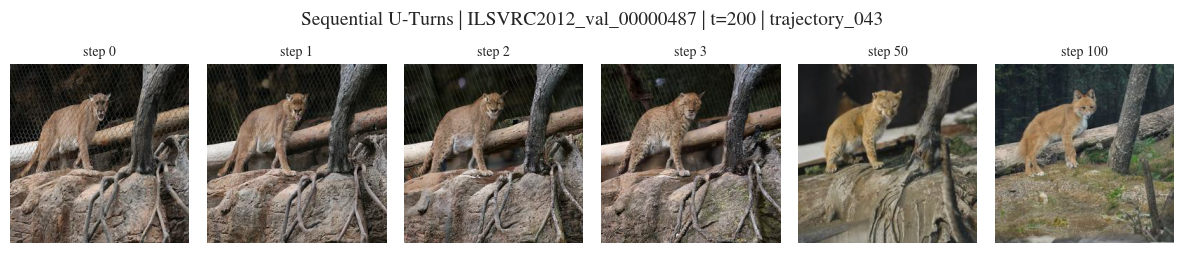

In [24]:
# --- MAIN ---
traj_dirs = list_trajectory_dirs(BASE_RESULTS_DIR, IMAGE_NAME, NOISE_STEP)
if not traj_dirs:
    raise FileNotFoundError('No trajectories found for this image/noise setting.')

if AUTO_SELECT:
    best = select_best_trajectory(traj_dirs)
    if best is None:
        raise FileNotFoundError('No trajectories with embeddings found.')
    trajectory_dir = best['dir']
    print('Selected trajectory: {}'.format(trajectory_dir))
    print('Drift={:.3f}, Roughness={:.3f}, Score={:.3f}'.format(best['drift'], best['rough'], best['score']))
else:
    trajectory_dir = traj_dirs[TRAJECTORY_INDEX]
    print('Using trajectory: {}'.format(trajectory_dir))

images, paths = load_trajectory_images(trajectory_dir)
if not images:
    raise FileNotFoundError('No uturn_*.jpeg/png images found in trajectory.')

# --- Classify original vs final image (top-1) ---
from guided_diffusion.torch_classifiers import load_classifier
from torchvision.models import ConvNeXt_Base_Weights
import torch as th
from torchvision.transforms import Resize

CLASSIFIER_NAME = 'convnext_base'
IMAGE_SIZE = 256

# Avoid heavy distributed init here; simple device selection is enough for 2 images
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
classifier, preprocess, _ = load_classifier(CLASSIFIER_NAME)
classifier.to(device).eval()

weights = ConvNeXt_Base_Weights.DEFAULT
categories = weights.meta.get('categories', None)

resize = Resize([IMAGE_SIZE, IMAGE_SIZE], Image.BICUBIC)

def classify_top1(pil_img):
    img = resize(pil_img)
    arr = np.array(img).astype(np.float32) / 127.5 - 1.0
    batch = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
    with th.no_grad():
        logits = classifier(preprocess(batch))
        probs = th.softmax(logits, dim=1)[0]
        idx = int(th.argmax(probs).item())
        conf = float(probs[idx].item())
    name = categories[idx] if categories is not None else str(idx)
    return idx, name, conf

orig_idx, orig_name, orig_conf = classify_top1(images[0])
final_idx, final_name, final_conf = classify_top1(images[-1])
print(f"Top-1 @ step 0: {orig_idx} ({orig_name}) p={orig_conf:.3f}")
print(f"Top-1 @ final:  {final_idx} ({final_name}) p={final_conf:.3f}")

steps = resolve_steps(len(images), STEPS_TO_PLOT, JUMP_FALLBACK)
title = 'Sequential U-Turns | {} | t={} | {}'.format(IMAGE_NAME, NOISE_STEP, os.path.basename(trajectory_dir))
out_path = os.path.join(OUTPUT_FIG_NAME)
plot_horizontal(images, steps, title, out_path)


## Susceptibility and $C_2(t)$ (Survival)

This section reproduces the susceptibility-style analysis and computes the discrete two-point survival correlation

$$ C_2(t)=\frac{1}{d}\sum_i\langle \delta_{x_i^{\,L}(0),\,x_i^{\,L}(t)}-\frac{1}{v}\rangle $$\n
We compute results for:
- A **single image**, averaging over trajectories (noise realizations).
- **All images**, averaging over images and trajectories.

Error bands are shaded SEM.

Consistency rule:
- For **single-image plots**, we group noise levels by their max U-turn length (e.g., 100 vs 200).
- For **all-images**, grouping by max length is optional.


In [ ]:
from tqdm import tqdm
try:
    from sklearn.cluster import MiniBatchKMeans
except Exception as e:
    MiniBatchKMeans = None
    print('Warning: sklearn not available. C2 will not run until sklearn is installed.')

# --- CONFIGURATION (Susceptibility + C2) ---
BASE_RESULTS_DIR = '/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns'
OUTPUT_DIR = '/work/pcsl/Noam/sequential_diffusion/results/plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMAGE_NAME = 'ILSVRC2012_val_00000729'
NOISE_STEPS_TO_ANALYZE = [25, 50, 75, 100, 150, 200]
NOISE_TMAX = 250  # set to the diffusion respacing used for generation (e.g., 250 or 1000)
NUM_TRAJECTORIES_TO_USE = 50  # None = use all

ANALYSIS_TYPE = 'total'  # 'total' (compare to t=0) or 'incremental' (t vs t-1)
USE_FLIP_AWARENESS = True

# Grouping by max U-turn length
GROUP_BY_MAX_STEPS_SINGLE = True
GROUP_BY_MAX_STEPS_ALL = False

# C2 (discrete) settings
C2_NUM_CLUSTERS = 50  # v
C2_RANDOM_STATE = 0
C2_FLIP_AWARE = True

# All-images speedups
MAX_IMAGES_FOR_ALL = None  # e.g., 20 for quick runs
C2_GLOBAL_CODEBOOK = True
C2_GLOBAL_SAMPLE_IMAGES = 20
C2_GLOBAL_SAMPLE_TRAJ = 5

# Susceptibility error bars (bootstrap across trajectories)
SUS_BOOTSTRAP = True
SUS_BOOTSTRAP_SAMPLES = 100
SUS_BOOTSTRAP_SEED = 0

print('Config loaded.')


In [ ]:
def list_image_dirs(base_dir, max_images=None):
    dirs = sorted([d for d in glob.glob(os.path.join(base_dir, 'ILSVRC*')) if os.path.isdir(d)])
    if max_images is not None:
        dirs = dirs[:max_images]
    return [os.path.basename(d) for d in dirs]

def list_trajectory_files(base_dir, image_name, noise_step, max_traj=None):
    experiment_dir = os.path.join(base_dir, image_name, f'noise_step_{noise_step}')
    search_pattern = os.path.join(experiment_dir, 'trajectory_*', 'trajectory_data.npz')
    files = sorted(glob.glob(search_pattern))
    if max_traj is not None:
        files = files[:max_traj]
    return files

def load_embeddings_list(trajectory_files):
    emb_list = []
    for f in trajectory_files:
        try:
            emb = np.load(f)['embeddings']
            emb_list.append(emb)
        except Exception:
            pass
    return emb_list

def min_steps(emb_list):
    return min(e.shape[0] for e in emb_list) if emb_list else 0

def calculate_change_between_steps(full_trajectory_embeddings, M, N, flip_aware=True):
    start_embeddings = full_trajectory_embeddings[M]
    end_embeddings = full_trajectory_embeddings[N]
    if M == 0 and flip_aware:
        start_grid = start_embeddings.reshape(7, 7, -1)
        start_grid_flipped = np.fliplr(start_grid)
        start_embeddings_flipped = start_grid_flipped.reshape(49, -1)
        delta_original = np.linalg.norm(end_embeddings - start_embeddings, axis=-1)
        delta_flipped = np.linalg.norm(end_embeddings - start_embeddings_flipped, axis=-1)
        delta_norms = np.minimum(delta_original, delta_flipped)
    else:
        delta_vectors = end_embeddings - start_embeddings
        delta_norms = np.linalg.norm(delta_vectors, axis=-1)
    return delta_norms

def compute_susceptibility_curve(emb_list, analysis_type='total', flip_aware=True,
                                  max_steps=None, bootstrap=False, n_boot=100, seed=0):
    if not emb_list:
        return {}
    max_steps = max_steps or min_steps(emb_list)
    num_uturn_steps = max_steps - 1
    susceptibility_vs_N = {}
    rng = np.random.default_rng(seed)

    for N in range(1, num_uturn_steps + 1):
        M = 0 if analysis_type == 'total' else N - 1
        all_delta_norms_for_step = []
        for emb in emb_list:
            if emb.shape[0] < N + 1:
                continue
            delta_norms = calculate_change_between_steps(emb, M, N, flip_aware)
            all_delta_norms_for_step.append(delta_norms)
        if len(all_delta_norms_for_step) < 2:
            continue
        stacked = np.array(all_delta_norms_for_step)  # [num_traj, 49]
        C_ij = np.cov(stacked.T)
        sum_C_ij = np.sum(C_ij)
        sum_C_ii = np.sum(np.diag(C_ij))
        susceptibility = sum_C_ij / sum_C_ii if sum_C_ii > 0 else 0.0

        sem = None
        if bootstrap:
            boots = []
            n_traj = len(all_delta_norms_for_step)
            for _ in range(n_boot):
                idx = rng.integers(0, n_traj, size=n_traj)
                sample = stacked[idx]
                Cb = np.cov(sample.T)
                sum_Cb = np.sum(Cb)
                sum_Cb_ii = np.sum(np.diag(Cb))
                sb = sum_Cb / sum_Cb_ii if sum_Cb_ii > 0 else 0.0
                boots.append(sb)
            sem = float(np.std(boots))
        susceptibility_vs_N[N] = {'mean': float(susceptibility), 'sem': sem}
    return susceptibility_vs_N

def fit_codebook(emb_list, num_clusters=50, random_state=0):
    if MiniBatchKMeans is None:
        raise RuntimeError('sklearn not available. Install scikit-learn to run C2.')
    X = np.concatenate([emb[0] for emb in emb_list], axis=0)
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=random_state, batch_size=2048)
    kmeans.fit(X)
    return kmeans

def fit_global_codebooks(base_dir, noise_steps, image_list, max_images, max_traj, num_clusters, seed):
    if MiniBatchKMeans is None:
        return {}
    codebooks = {}
    use_images = image_list[:max_images] if max_images is not None else image_list
    for noise_step in noise_steps:
        all_emb = []
        for img in use_images:
            traj_files = list_trajectory_files(base_dir, img, noise_step, max_traj)
            emb_list = load_embeddings_list(traj_files)
            if not emb_list:
                continue
            for emb in emb_list:
                all_emb.append(emb[0])
        if not all_emb:
            continue
        X = np.concatenate(all_emb, axis=0)
        kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=seed, batch_size=2048)
        kmeans.fit(X)
        codebooks[noise_step] = kmeans
    return codebooks

def compute_c2_curve(emb_list, kmeans, num_clusters, flip_aware=False, max_steps=None):
    if not emb_list:
        return {}
    max_steps = max_steps or min_steps(emb_list)
    num_uturn_steps = max_steps - 1
    c2_vs_t = {}
    for t in range(0, num_uturn_steps + 1):
        traj_vals = []
        for emb in emb_list:
            if emb.shape[0] < t + 1:
                continue
            labels_0 = kmeans.predict(emb[0])
            labels_t = kmeans.predict(emb[t])
            if flip_aware:
                grid = labels_0.reshape(7, 7)
                grid_flip = np.fliplr(grid)
                labels_0_flip = grid_flip.reshape(-1)
                match_orig = np.mean(labels_t == labels_0)
                match_flip = np.mean(labels_t == labels_0_flip)
                match = max(match_orig, match_flip)
            else:
                match = np.mean(labels_t == labels_0)
            c2 = match - (1.0 / num_clusters)
            traj_vals.append(c2)
        if traj_vals:
            mean = float(np.mean(traj_vals))
            sem = float(np.std(traj_vals) / np.sqrt(len(traj_vals))) if len(traj_vals) > 1 else None
            c2_vs_t[t] = {'mean': mean, 'sem': sem}
    return c2_vs_t


In [ ]:
# --- SINGLE IMAGE: Susceptibility + C2 (group by max steps) ---
single_sus = {}
single_c2 = {}

emb_cache = {}
max_steps_by_noise = {}
for noise_step in NOISE_STEPS_TO_ANALYZE:
    traj_files = list_trajectory_files(BASE_RESULTS_DIR, IMAGE_NAME, noise_step, NUM_TRAJECTORIES_TO_USE)
    emb_list = load_embeddings_list(traj_files)
    emb_cache[noise_step] = emb_list
    if emb_list:
        max_steps_by_noise[noise_step] = min_steps(emb_list)

groups = {}
if GROUP_BY_MAX_STEPS_SINGLE:
    for ns, ms in max_steps_by_noise.items():
        groups.setdefault(ms, []).append(ns)
else:
    groups = {None: list(max_steps_by_noise.keys())}

for group_steps, noise_list in groups.items():
    single_sus[group_steps] = {}
    single_c2[group_steps] = {}
    for noise_step in sorted(noise_list):
        emb_list = emb_cache.get(noise_step, [])
        if not emb_list:
            print(f'[single] No data for noise_step={noise_step}')
            continue
        max_steps = group_steps or max_steps_by_noise.get(noise_step)
        single_sus[group_steps][noise_step] = compute_susceptibility_curve(
            emb_list, ANALYSIS_TYPE, USE_FLIP_AWARENESS,
            max_steps=max_steps,
            bootstrap=SUS_BOOTSTRAP, n_boot=SUS_BOOTSTRAP_SAMPLES, seed=SUS_BOOTSTRAP_SEED
        )
        if MiniBatchKMeans is not None:
            kmeans = fit_codebook(emb_list, C2_NUM_CLUSTERS, C2_RANDOM_STATE)
            single_c2[group_steps][noise_step] = compute_c2_curve(
                emb_list, kmeans, C2_NUM_CLUSTERS, C2_FLIP_AWARE, max_steps=max_steps
            )

print('Single-image metrics computed.')


In [ ]:
# --- PLOT: SINGLE IMAGE (shaded SEM, grouped by length) ---
for group_steps, sus_by_noise in single_sus.items():
    if not sus_by_noise:
        continue
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, len(sus_by_noise)))
    for i, t in enumerate(sorted(sus_by_noise.keys())):
        steps = list(sus_by_noise[t].keys())
        means = [sus_by_noise[t][s]['mean'] for s in steps]
        sems = [sus_by_noise[t][s]['sem'] or 0.0 for s in steps]
        rho = t / float(NOISE_TMAX)
        ax1.plot(steps, means, color=colors[i], label=f'ρ={rho:.2f}')
        ax1.fill_between(steps, np.array(means)-np.array(sems), np.array(means)+np.array(sems),
                        color=colors[i], alpha=0.2)
    ax1.set_xlabel('Number of U-turns (t)')
    ax1.set_ylabel('Susceptibility')
    ax1.set_title(f'Susceptibility | {IMAGE_NAME} | max steps={group_steps}')
    ax1.legend(title='noise level (ρ)')
    ax1.grid(True, linestyle='--', alpha=0.5)

    c2_by_noise = single_c2.get(group_steps, {})
    if c2_by_noise:
        for i, t in enumerate(sorted(c2_by_noise.keys())):
            steps = list(c2_by_noise[t].keys())
            means = [c2_by_noise[t][s]['mean'] for s in steps]
            sems = [c2_by_noise[t][s]['sem'] or 0.0 for s in steps]
            rho = t / float(NOISE_TMAX)
            ax2.plot(steps, means, color=colors[i], label=f'ρ={rho:.2f}')
            ax2.fill_between(steps, np.array(means)-np.array(sems), np.array(means)+np.array(sems),
                            color=colors[i], alpha=0.2)
        ax2.set_xlabel('Number of U-turns (t)')
        ax2.set_ylabel('C2(t)')
        ax2.set_title(f'C2(t) | {IMAGE_NAME} | max steps={group_steps}')
        ax2.legend(title='noise level (ρ)')
        ax2.grid(True, linestyle='--', alpha=0.5)
    else:
        ax2.axis('off')
        ax2.set_title('C2(t) not computed (sklearn missing)')

    plt.tight_layout()
    suffix = f'maxsteps_{group_steps}' if group_steps else 'mixed'
    out_path = os.path.join(OUTPUT_DIR, f'susceptibility_c2_single_{IMAGE_NAME}_{suffix}.pdf')
    plt.savefig(out_path, dpi=300)
    print(f'✅ Saved: {out_path}')
    if 'export_and_link' in globals():
        export_and_link(out_path)
    plt.show()


In [ ]:
# --- ALL IMAGES: Susceptibility + C2 ---
all_images = list_image_dirs(BASE_RESULTS_DIR, MAX_IMAGES_FOR_ALL)

global_codebooks = {}
if C2_GLOBAL_CODEBOOK and MiniBatchKMeans is not None:
    global_codebooks = fit_global_codebooks(
        BASE_RESULTS_DIR, NOISE_STEPS_TO_ANALYZE, all_images,
        C2_GLOBAL_SAMPLE_IMAGES, C2_GLOBAL_SAMPLE_TRAJ,
        C2_NUM_CLUSTERS, C2_RANDOM_STATE
    )

all_sus_by_noise = {t: [] for t in NOISE_STEPS_TO_ANALYZE}
all_c2_by_noise = {t: [] for t in NOISE_STEPS_TO_ANALYZE}

for img in tqdm(all_images, desc='Images'):
    for noise_step in NOISE_STEPS_TO_ANALYZE:
        traj_files = list_trajectory_files(BASE_RESULTS_DIR, img, noise_step, NUM_TRAJECTORIES_TO_USE)
        emb_list = load_embeddings_list(traj_files)
        if not emb_list:
            continue
        max_steps = min_steps(emb_list)
        sus_curve = compute_susceptibility_curve(
            emb_list, ANALYSIS_TYPE, USE_FLIP_AWARENESS,
            max_steps=max_steps, bootstrap=False
        )
        if sus_curve:
            all_sus_by_noise[noise_step].append(sus_curve)
        if MiniBatchKMeans is not None:
            if C2_GLOBAL_CODEBOOK and noise_step in global_codebooks:
                kmeans = global_codebooks[noise_step]
            else:
                kmeans = fit_codebook(emb_list, C2_NUM_CLUSTERS, C2_RANDOM_STATE)
            c2_curve = compute_c2_curve(
                emb_list, kmeans, C2_NUM_CLUSTERS, C2_FLIP_AWARE, max_steps=max_steps
            )
            if c2_curve:
                all_c2_by_noise[noise_step].append(c2_curve)

print('All-images metrics computed.')


In [ ]:
# --- PLOT: ALL IMAGES (shaded SEM across images) ---
def average_curves_with_sem(curve_list, key='mean'):
    if not curve_list:
        return {}
    common_steps = set(curve_list[0].keys())
    for c in curve_list[1:]:
        common_steps &= set(c.keys())
    common_steps = sorted(common_steps)
    avg = {}
    for s in common_steps:
        vals = [c[s][key] for c in curve_list]
        mean = float(np.mean(vals))
        sem = float(np.std(vals) / np.sqrt(len(vals))) if len(vals) > 1 else None
        avg[s] = {'mean': mean, 'sem': sem}
    return avg

avg_sus = {t: average_curves_with_sem(curves) for t, curves in all_sus_by_noise.items()}
avg_c2 = {t: average_curves_with_sem(curves) for t, curves in all_c2_by_noise.items()}

if any(avg_sus.values()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, len(NOISE_STEPS_TO_ANALYZE)))
    for i, t in enumerate(sorted(avg_sus.keys())):
        curve = avg_sus[t]
        if not curve:
            continue
        steps = list(curve.keys())
        means = [curve[s]['mean'] for s in steps]
        sems = [curve[s]['sem'] or 0.0 for s in steps]
        rho = t / float(NOISE_TMAX)
        ax1.plot(steps, means, color=colors[i], label=f'ρ={rho:.2f}')
        ax1.fill_between(steps, np.array(means)-np.array(sems), np.array(means)+np.array(sems),
                        color=colors[i], alpha=0.2)
    ax1.set_xlabel('Number of U-turns (t)')
    ax1.set_ylabel('Susceptibility')
    ax1.set_title('Susceptibility | All images')
    ax1.legend(title='noise level (ρ)')
    ax1.grid(True, linestyle='--', alpha=0.5)

    if any(avg_c2.values()):
        for i, t in enumerate(sorted(avg_c2.keys())):
            curve = avg_c2[t]
            if not curve:
                continue
            steps = list(curve.keys())
            means = [curve[s]['mean'] for s in steps]
            sems = [curve[s]['sem'] or 0.0 for s in steps]
            rho = t / float(NOISE_TMAX)
            ax2.plot(steps, means, color=colors[i], label=f'ρ={rho:.2f}')
            ax2.fill_between(steps, np.array(means)-np.array(sems), np.array(means)+np.array(sems),
                            color=colors[i], alpha=0.2)
        ax2.set_xlabel('Number of U-turns (t)')
        ax2.set_ylabel('C2(t)')
        ax2.set_title('C2(t) | All images')
        ax2.legend(title='noise level (ρ)')
        ax2.grid(True, linestyle='--', alpha=0.5)
    else:
        ax2.axis('off')
        ax2.set_title('C2(t) not computed (sklearn missing)')

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, 'susceptibility_c2_all_images.pdf')
    plt.savefig(out_path, dpi=300)
    print(f'✅ Saved: {out_path}')
    if 'export_and_link' in globals():
        export_and_link(out_path)
    plt.show()


## Latent Cosine Similarity vs Normalized U-turns (CNN)


/tmp/2549906/ipykernel_444811/492786212.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Saved: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results/plots/latent_cosine_norm_uturns_ILSVRC2012_val_00000729_noise100.pdf


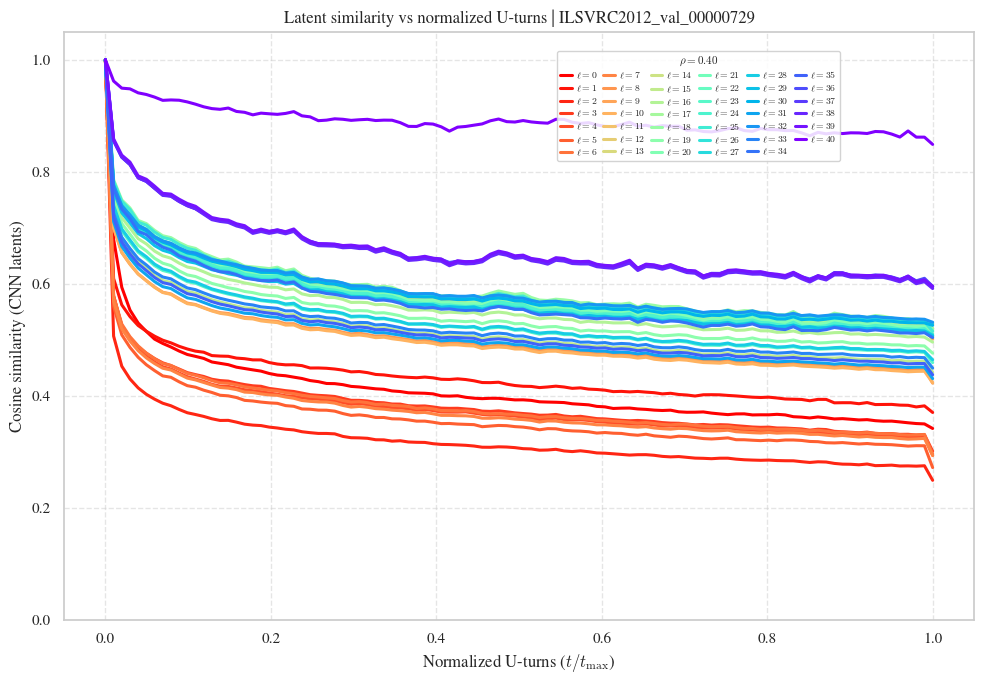

In [62]:
import os
import glob
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_theme(style="whitegrid")
if "apply_pub_style" in globals():
    apply_pub_style()
plt.rcParams['figure.figsize'] = [10, 7]

# --- CONFIGURATION ---
SEQ_RESULTS_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"
CLASSIFIER_NAME = "convnext_base"
IMAGE_NAME = "ILSVRC2012_val_00000729"
NOISE_STEPS = [100]  # list of noise steps to plot
NOISE_TMAX = 250  # diffusion respacing used for generation

INCLUDE_T0_BASELINE = True
USE_SEM_SHADE = False
MIN_TRAJ_SAMPLES = 1

USE_INSET_LEGEND = True
LEGEND_FONT_SIZE = 7
LEGEND_MAX_COLS = 6
LEGEND_INSET_WIDTH = "45%"
LEGEND_INSET_HEIGHT = "95%"

OUTPUT_DIR_LATENT = os.path.join(SEQ_RESULTS_DIR, "plots")
os.makedirs(OUTPUT_DIR_LATENT, exist_ok=True)

# --- HELPERS ---
def layer_sort_key(name):
    # Ensure input -> output ordering for ConvNeXt-style names
    if name == "classifier" or name.endswith("head"):
        return (2, 999)
    m = re.search(r"features\.(\d+)", name)
    if m:
        return (1, int(m.group(1)))
    return (0, name)


def load_layer_cosine(results_file, min_traj_samples=1, include_t0=True):
    with open(results_file, "rb") as f:
        results_by_step = pickle.load(f)

    steps = sorted(results_by_step.keys())
    if not steps:
        return {}, [], 0

    max_step = max(steps)

    layer_names = set()
    for step in steps:
        for layer, metrics in results_by_step[step].items():
            if isinstance(metrics, dict) and "cosine" in metrics:
                layer_names.add(layer)

    layer_names = sorted(layer_names, key=layer_sort_key)

    data = {}
    for layer in layer_names:
        xs, ys, sems = [], [], []
        for step in steps:
            metrics = results_by_step[step].get(layer)
            if not metrics or "cosine" not in metrics:
                continue
            vals = np.array(metrics["cosine"], dtype=float)
            vals = vals[np.isfinite(vals)]
            if len(vals) < min_traj_samples:
                continue
            xs.append(step / float(max_step))
            ys.append(float(np.mean(vals)))
            sems.append(float(np.std(vals) / np.sqrt(len(vals))) if len(vals) > 1 else 0.0)
        if include_t0:
            xs = [0.0] + xs
            ys = [1.0] + ys
            sems = [0.0] + sems
        data[layer] = {"x": xs, "y": ys, "sem": sems}

    return data, layer_names, max_step


for noise in NOISE_STEPS:
    results_file = os.path.join(
        SEQ_RESULTS_DIR, CLASSIFIER_NAME, IMAGE_NAME, f"noise_{noise}", "sequential_activations_v2.pk"
    )

    if not os.path.exists(results_file):
        print(f"Missing file: {results_file}")
        continue

    layer_data, layer_names, max_step = load_layer_cosine(
        results_file, min_traj_samples=MIN_TRAJ_SAMPLES, include_t0=INCLUDE_T0_BASELINE
    )

    if not layer_data:
        print(f"No data loaded for noise={noise}")
        continue

    colors = plt.cm.rainbow(np.linspace(1, 0, len(layer_names)))  # red=input, violet=output

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    for i, layer in enumerate(layer_names):
        d = layer_data[layer]
        if not d["x"]:
            continue
        label = rf"$\ell={i}$"
        ax.plot(d["x"], d["y"], color=colors[i], linewidth=2.2, label=label)
        if USE_SEM_SHADE:
            ax.fill_between(
                d["x"],
                np.array(d["y"]) - np.array(d["sem"]),
                np.array(d["y"]) + np.array(d["sem"]),
                color=colors[i],
                alpha=0.15,
            )

    rho = noise / float(NOISE_TMAX)
    ax.set_xlabel(r"Normalized U-turns ($t/t_{\max}$)")
    ax.set_ylabel("Cosine similarity (CNN latents)")
    ax.set_title(f"Latent similarity vs normalized U-turns | {IMAGE_NAME}")
    ax.set_ylim(0.0, 1.05)
    ax.grid(True, linestyle="--", alpha=0.5)

    handles, labels = ax.get_legend_handles_labels()
    if USE_INSET_LEGEND:
        n_layers = len(labels)
        # Aim for ~6-10 rows by adjusting columns
        ncol = max(2, min(LEGEND_MAX_COLS, int(np.ceil(n_layers / 8))))
        legend_ax = inset_axes(ax, width=LEGEND_INSET_WIDTH, height=LEGEND_INSET_HEIGHT, loc="center right", borderpad=0.8)
        legend_ax.axis("off")
        legend_ax.legend(
            handles, labels,
            title=rf"$\rho={rho:.2f}$",
            loc="upper left",
            fontsize=LEGEND_FONT_SIZE,
            title_fontsize=LEGEND_FONT_SIZE + 1,
            ncol=ncol,
            frameon=True,
            framealpha=0.85,
            borderpad=0.3,
            labelspacing=0.25,
            handlelength=1.2,
            handletextpad=0.4,
            columnspacing=0.6,
        )
    else:
        ax.legend(title=rf"$\rho={rho:.2f}$", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=LEGEND_FONT_SIZE)

    plt.tight_layout()

    fname = f"latent_cosine_norm_uturns_{IMAGE_NAME}_noise{noise}.pdf"
    out_path = os.path.join(OUTPUT_DIR_LATENT, fname)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")

    # Optional: make downloadable in JupyterLab via notebooks/_exports
    if "export_to_notebook_dir" in globals():
        export_to_notebook_dir(out_path)

# --- OPTIONAL: MOCK LEGEND STRESS TEST (40 layers) ---
MOCK_LEGEND_TEST = False
if MOCK_LEGEND_TEST:
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 7))
    n_layers = 40
    colors2 = plt.cm.rainbow(np.linspace(1, 0, n_layers))
    x = np.linspace(0, 1, 20)
    for i in range(n_layers):
        y = 0.2 + 0.8 * np.exp(-x * (i + 1) / 12.0)
        ax2.plot(x, y, color=colors2[i], linewidth=1.8, label=rf"$\ell={i}$")
    ax2.set_title("Mock legend stress test (40 layers)")
    ax2.set_xlabel(r"Normalized U-turns ($t/t_{\max}$)")
    ax2.set_ylabel("Cosine similarity")
    ax2.grid(True, linestyle="--", alpha=0.5)
    handles2, labels2 = ax2.get_legend_handles_labels()
    ncol2 = max(2, min(LEGEND_MAX_COLS, int(np.ceil(len(labels2) / 8))))
    legend_ax2 = inset_axes(ax2, width=LEGEND_INSET_WIDTH, height=LEGEND_INSET_HEIGHT, loc="center right", borderpad=0.8)
    legend_ax2.axis("off")
    legend_ax2.legend(
        handles2, labels2,
        title=r"$\rho=0.40$",
        loc="upper left",
        fontsize=LEGEND_FONT_SIZE,
        title_fontsize=LEGEND_FONT_SIZE + 1,
        ncol=ncol2,
        frameon=True,
        framealpha=0.85,
        borderpad=0.3,
        labelspacing=0.25,
        handlelength=1.2,
        handletextpad=0.4,
        columnspacing=0.6,
    )
    plt.tight_layout()
    plt.show()


## Guided vs Unguided (Dog→Cat) Latent Survival

This section compares ConvNeXt latents along guided (meta-cat steering) vs unguided sequential U-turns, and also plots meta-class (dog/cat) probability mass over steps.


Config loaded.
Using GUIDED_DIR: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039
No guided images found in /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039
No unguided images found in /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_100/trajectory_000/trajectory_data.npz
Guided trajectories: 0
Unguided trajectories: 0
Guided length ref: None
Using layers: ['features.0', 'features.2', 'features.4', 'features.6', 'classifier']
Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039/plots/guided_vs_unguided_latent_similarity_grid.pdf
Copied to exports: notebooks/_exports/guided_vs_unguided_latent_similarity_grid.pdf


NameError: name 'logits_unguided' is not defined

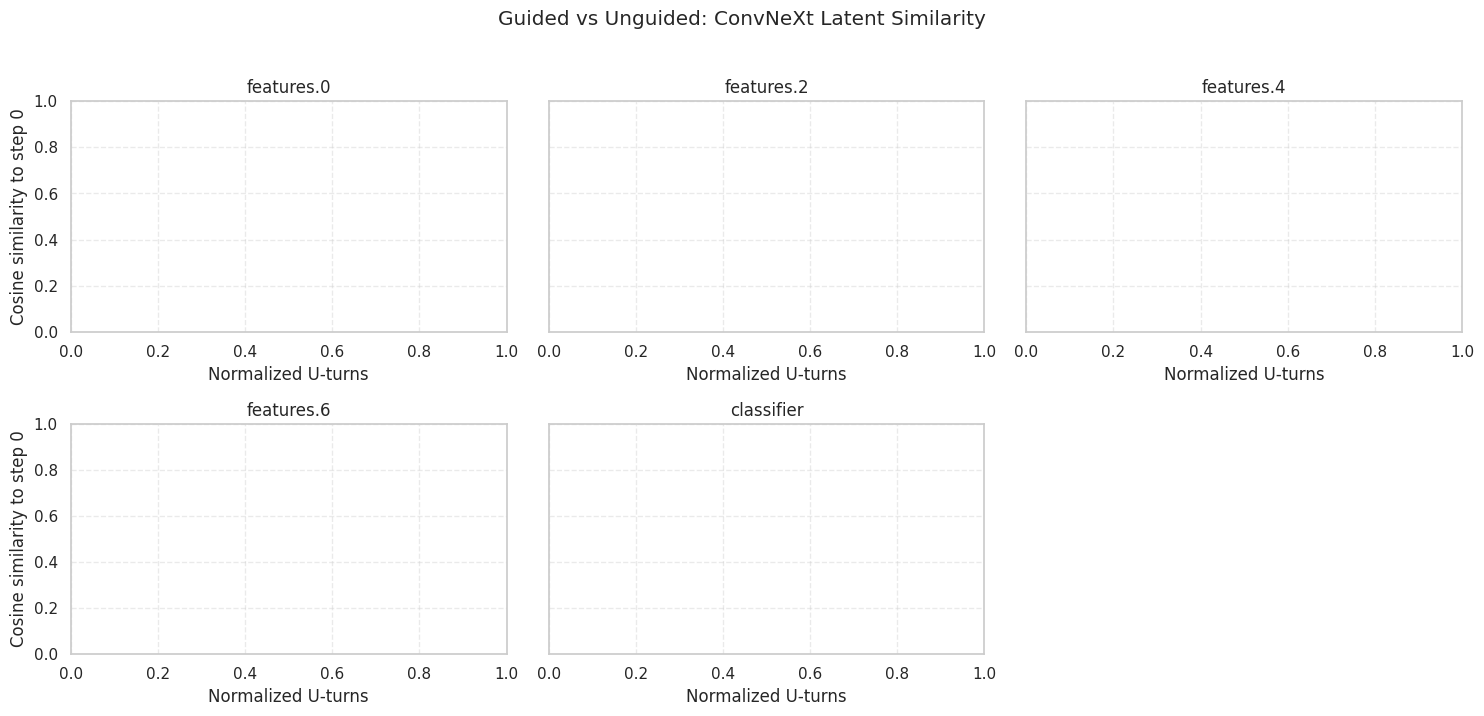

In [57]:
import os
import glob
import re
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from torchvision.transforms import Resize

from guided_diffusion import dist_util
from guided_diffusion.torch_classifiers import load_classifier

sns.set_theme(style="whitegrid")
if "apply_pub_style" in globals():
    apply_pub_style()

# --- CONFIGURATION ---
GUIDED_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0"
AUTO_GUIDED_DIR = True  # auto-pick latest run under GUIDED_ROOT if set
GUIDED_ROOT = '/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat'
UNGUIDED_DIR = "/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_100/trajectory_000"

CLASSIFIER_NAME = "convnext_base"
IMAGE_SIZE = 256
NORMALIZE_X = True
MAX_STEPS = None  # e.g., 50 to truncate

# Averaging across trajectories
AVERAGE_UNGUIDED = True
MAX_UNGUIDED_TRAJS = None  # e.g., 5 for speed
AVERAGE_GUIDED = False
SYNC_UNGUIDED_TO_GUIDED = True  # trim unguided to guided length
GUIDED_DIRS = [GUIDED_DIR]

SHADE_SEM = True

# Montage example
MAKE_MONTAGE = True
MONTAGE_FRAMES = 8

# ConvNeXt layers (update if needed)
LAYER_KEYS = [
    "features.0", "features.1", "features.2", "features.3",
    "features.4", "features.5", "features.6", "features.7",
    "classifier",
]

AUTO_DISCOVER_LAYERS = False

# Meta-class indices (consistent with steered_sequential_uturns_meta.py)
DOG_INDICES = list(range(151, 269))
CAT_INDICES = list(range(281, 286))

USE_STEERING_DATA_FOR_GUIDED_META = True  # use steering_data.npz if present

# Plotting
PLOT_ALL_LAYERS_GRID = True
GRID_COLS = 3
GUIDED_COLOR = "crimson"
UNGUIDED_COLOR = "royalblue"

OUTPUT_DIR_LATENT = os.path.join(GUIDED_DIR, "plots")
os.makedirs(OUTPUT_DIR_LATENT, exist_ok=True)

print("Config loaded.")

# --- HELPERS ---

def list_images_with_steps(base_dir, patterns, regex, max_steps=None):
    if isinstance(patterns, str):
        patterns = [patterns]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir, pat)))
    items = []
    for f in files:
        m = re.search(regex, os.path.basename(f))
        if m:
            items.append((int(m.group(1)), f))
    items = sorted(items, key=lambda x: x[0])
    if max_steps is not None:
        items = [it for it in items if it[0] <= max_steps]
    return [p for _, p in items]


# If base_dir contains trajectory_* subfolders, return those; otherwise treat base_dir as a trajectory dir
def resolve_trajectory_dirs(base_dir, max_traj=None):
    traj_dirs = sorted(glob.glob(os.path.join(base_dir, "trajectory_*")))
    if traj_dirs:
        if max_traj is not None:
            traj_dirs = traj_dirs[:max_traj]
        return traj_dirs
    return [base_dir]


# Fallback export helper (in case export_to_notebook_dir was not run)
def maybe_export(path):
    if "export_to_notebook_dir" in globals():
        export_to_notebook_dir(path)
        return
    export_dir = os.path.join("notebooks", "_exports")
    os.makedirs(export_dir, exist_ok=True)
    dst = os.path.join(export_dir, os.path.basename(path))
    shutil.copy(path, dst)
    print(f"Copied to exports: {dst}")

# Montage helper
def sample_indices(n, num_samples):
    if n <= num_samples:
        return list(range(n))
    return list(np.linspace(0, n - 1, num_samples, dtype=int))


def make_montage(image_paths, title, out_path):
    if not image_paths:
        print(f"No images for montage: {title}")
        return
    idxs = sample_indices(len(image_paths), MONTAGE_FRAMES)
    fig, axes = plt.subplots(1, len(idxs), figsize=(2. * len(idxs), 2.5))
    if len(idxs) == 1:
        axes = [axes]
    for ax, i in zip(axes, idxs):
        img = Image.open(image_paths[i]).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"t={i}", fontsize=9)
        ax.axis("off")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()



def infer_latest_guided_dir(root, fallback=None):
    if root is None:
        return fallback
    cands = sorted(glob.glob(os.path.join(root, 'noise_*')))
    if not cands:
        return fallback
    def score_dir(d):
        s = os.path.join(d, 'steering_data.npz')
        return os.path.getmtime(s) if os.path.exists(s) else os.path.getmtime(d)
    cands = sorted(cands, key=score_dir, reverse=True)
    return cands[0]
def load_classifier_and_layers():
    dist_util.setup_dist()
    device = dist_util.dev()
    classifier, preprocess, module_names = load_classifier(CLASSIFIER_NAME)
    classifier.to(device).eval()
    if AUTO_DISCOVER_LAYERS:
        layer_keys = module_names
    else:
        layer_keys = [k for k in LAYER_KEYS if k in module_names]
        missing = [k for k in LAYER_KEYS if k not in module_names]
        if missing:
            print(f"Warning: missing layer keys: {missing}")
    return classifier, preprocess, device, layer_keys

def collect_activations(image_paths, classifier, preprocess, device, layer_keys):
    modules = dict(classifier.named_modules())
    acts = {k: [] for k in layer_keys}
    hooks = []
    def make_hook(name):
        def hook(module, inp, out):
            acts[name].append(out)
        return hook
    for k in layer_keys:
        if k in modules:
            hooks.append(modules[k].register_forward_hook(make_hook(k)))
    logits_list = []
    resize = Resize([IMAGE_SIZE, IMAGE_SIZE], Image.BICUBIC)
    for p in image_paths:
        img = Image.open(p).convert('RGB')
        img = resize(img)
        arr = np.array(img).astype(np.float32) / 127.5 - 1.0
        batch = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
        with th.no_grad():
            logits = classifier(preprocess(batch))
        logits_list.append(logits.detach().cpu()[0])
    for h in hooks:
        h.remove()
    act_out = {}
    for name, outs in acts.items():
        vecs = []
        for o in outs:
            t = o.detach().cpu()
            if t.ndim == 4:
                t = t.mean(dim=[2, 3])
            elif t.ndim == 3:
                t = t.mean(dim=1)
            if t.ndim == 2:
                t = t[0]
            vecs.append(t.numpy())
        act_out[name] = np.stack(vecs, axis=0) if vecs else None
    logits_tensor = th.stack(logits_list, dim=0) if logits_list else None
    return act_out, logits_tensor

def cosine_curve(v):
    v = np.array(v)
    if v.ndim == 1:
        v = v[:, None]
    base = v[0]
    denom = (np.linalg.norm(base) * np.linalg.norm(v, axis=1) + 1e-8)
    return (v @ base) / denom

def average_curves(curve_list):
    if not curve_list:
        return {}, {}
    keys = curve_list[0].keys()
    mean_curves = {}
    sem_curves = {}
    for k in keys:
        series = [np.array(d[k]) for d in curve_list if d.get(k) is not None]
        if not series:
            continue
        min_len = min(len(s) for s in series)
        arr = np.stack([s[:min_len] for s in series], axis=0)
        mean_curves[k] = arr.mean(axis=0)
        sem_curves[k] = arr.std(axis=0) / np.sqrt(arr.shape[0]) if arr.shape[0] > 1 else None
    return mean_curves, sem_curves

def normalize_x(n):
    if n <= 1:
        return np.arange(n)
    return np.linspace(0, 1, n) if NORMALIZE_X else np.arange(n)

def meta_probs_from_logits(logits_tensor):
    probs = th.softmax(logits_tensor, dim=1)
    dog = probs[:, DOG_INDICES].sum(dim=1).cpu().numpy()
    cat = probs[:, CAT_INDICES].sum(dim=1).cpu().numpy()
    return dog, cat

# Auto-pick latest guided directory if requested
if AUTO_GUIDED_DIR:
    GUIDED_DIR = infer_latest_guided_dir(GUIDED_ROOT, fallback=GUIDED_DIR)
    GUIDED_DIRS = [GUIDED_DIR]
    OUTPUT_DIR_LATENT = os.path.join(GUIDED_DIR, 'plots')
    os.makedirs(OUTPUT_DIR_LATENT, exist_ok=True)
    print(f'Using GUIDED_DIR: {GUIDED_DIR}')

# --- 1) Load guided + unguided image sequences ---

# Guided image sequences (possibly multiple dirs)
all_guided_image_lists = []
for gdir in GUIDED_DIRS:
    imgs = list_images_with_steps(gdir, ["step_*.jpeg", "step_*.png"], r"step_(\d+)\.(jpeg|png)", MAX_STEPS)
    if imgs:
        all_guided_image_lists.append(imgs)
    else:
        print(f"No guided images found in {gdir}")

# Unguided image sequences (single dir or list of trajectory_* subdirs)
all_unguided_image_lists = []
for udir in resolve_trajectory_dirs(UNGUIDED_DIR, MAX_UNGUIDED_TRAJS if AVERAGE_UNGUIDED else 1):
    imgs = list_images_with_steps(udir, ["uturn_*.jpeg", "uturn_*.png"], r"uturn_(\d+)\.(jpeg|png)", MAX_STEPS)
    if imgs:
        all_unguided_image_lists.append(imgs)
    else:
        print(f"No unguided images found in {udir}")


# --- Truncate guided image lists to match steering_data length (avoid mixing old steps) ---
guided_len_limits = []
for gdir in GUIDED_DIRS:
    n = None
    data_path = os.path.join(gdir, "steering_data.npz")
    if os.path.exists(data_path):
        data = np.load(data_path)
        if "probs_cat" in data:
            n = len(data["probs_cat"])
        elif "probs_target" in data:
            n = len(data["probs_target"])
    guided_len_limits.append(n)
guided_len_ref = None
for i, n in enumerate(guided_len_limits):
    if n is not None and i < len(all_guided_image_lists):
        # filter by step index to be safe
        filt = []
        for p in all_guided_image_lists[i]:
            m = re.search(r"step_(\d+)", os.path.basename(p))
            if m is None:
                continue
            if int(m.group(1)) < n:
                filt.append(p)
        all_guided_image_lists[i] = filt
        guided_len_ref = n if guided_len_ref is None else min(guided_len_ref, n)

# Optionally sync unguided length to guided length
if SYNC_UNGUIDED_TO_GUIDED and guided_len_ref is not None:
    for j in range(len(all_unguided_image_lists)):
        filt = []
        for p in all_unguided_image_lists[j]:
            m = re.search(r"uturn_(\d+)", os.path.basename(p))
            if m is None:
                continue
            if int(m.group(1)) < guided_len_ref:
                filt.append(p)
        all_unguided_image_lists[j] = filt


print(f"Guided trajectories: {len(all_guided_image_lists)}")
print(f"Unguided trajectories: {len(all_unguided_image_lists)}")
print(f'Guided length ref: {guided_len_ref}')
if all_guided_image_lists:
    print("Guided sample:", all_guided_image_lists[0][0], all_guided_image_lists[0][-1])
if all_unguided_image_lists:
    print("Unguided sample:", all_unguided_image_lists[0][0], all_unguided_image_lists[0][-1])

# Example montages
if MAKE_MONTAGE and all_guided_image_lists:
    out_path = os.path.join(OUTPUT_DIR_LATENT, "montage_guided.pdf")
    make_montage(all_guided_image_lists[0], "Guided trajectory", out_path)
if MAKE_MONTAGE and all_unguided_image_lists:
    out_path = os.path.join(OUTPUT_DIR_LATENT, "montage_unguided.pdf")
    make_montage(all_unguided_image_lists[0], "Unguided trajectory", out_path)

# --- 2) Collect classifier activations ---
classifier, preprocess, device, layer_keys = load_classifier_and_layers()

print(f"Using layers: {layer_keys}")

# Compute curves per guided trajectory
all_guided_curves = []
all_guided_logits = []
for imgs in all_guided_image_lists:
    acts, logits = collect_activations(imgs, classifier, preprocess, device, layer_keys)
    curves = {k: cosine_curve(v) for k, v in acts.items()}
    all_guided_curves.append(curves)
    if logits is not None:
        all_guided_logits.append(logits)

# Compute curves per unguided trajectory
all_unguided_curves = []
all_unguided_logits = []
for imgs in all_unguided_image_lists:
    acts, logits = collect_activations(imgs, classifier, preprocess, device, layer_keys)
    curves = {k: cosine_curve(v) for k, v in acts.items()}
    all_unguided_curves.append(curves)
    if logits is not None:
        all_unguided_logits.append(logits)

# Average if requested
if AVERAGE_GUIDED and len(all_guided_curves) > 1:
    guided_curves, guided_sem = average_curves(all_guided_curves)
else:
    guided_curves = all_guided_curves[0] if all_guided_curves else {}
    guided_sem = {}

if AVERAGE_UNGUIDED and len(all_unguided_curves) > 1:
    unguided_curves, unguided_sem = average_curves(all_unguided_curves)
else:
    unguided_curves = all_unguided_curves[0] if all_unguided_curves else {}
    unguided_sem = {}

# For x-axis, use first trajectory lengths
x_guided = normalize_x(len(all_guided_image_lists[0]) if all_guided_image_lists else 0)
x_unguided = normalize_x(len(all_unguided_image_lists[0]) if all_unguided_image_lists else 0)

# --- 3) Cosine similarity vs step (guided vs unguided) ---

if PLOT_ALL_LAYERS_GRID:
    n = len(layer_keys)
    ncols = GRID_COLS
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3.5 * nrows), sharey=True)
    axes = np.array(axes).reshape(-1)

    for idx, layer in enumerate(layer_keys):
        ax = axes[idx]
        if guided_curves.get(layer):
            ax.plot(x_guided, guided_curves[layer], color=GUIDED_COLOR, label="guided")
            if SHADE_SEM and guided_sem.get(layer) is not None:
                y = np.array(guided_curves[layer])
                s = np.array(guided_sem[layer])
                ax.fill_between(x_guided[:len(y)], y - s, y + s, color=GUIDED_COLOR, alpha=0.15)
        if unguided_curves.get(layer):
            ax.plot(x_unguided, unguided_curves[layer], color=UNGUIDED_COLOR, linestyle="--", label="unguided")
            if SHADE_SEM and unguided_sem.get(layer) is not None:
                y = np.array(unguided_curves[layer])
                s = np.array(unguided_sem[layer])
                ax.fill_between(x_unguided[:len(y)], y - s, y + s, color=UNGUIDED_COLOR, alpha=0.15)

        ax.set_title(layer)
        ax.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
        if idx % ncols == 0:
            ax.set_ylabel("Cosine similarity to step 0")
        ax.grid(True, linestyle="--", alpha=0.4)

    # Hide any unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # One legend for whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    fig.suptitle("Guided vs Unguided: ConvNeXt Latent Similarity", y=1.02)
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR_LATENT, "guided_vs_unguided_latent_similarity_grid.pdf")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")

    maybe_export(out_path)

# --- 4) Meta-class survival (dog vs cat probabilities) ---

# Guided: either use steering_data.npz or compute from logits
if USE_STEERING_DATA_FOR_GUIDED_META and os.path.exists(os.path.join(GUIDED_DIR, "steering_data.npz")):
    data = np.load(os.path.join(GUIDED_DIR, "steering_data.npz"))
    guided_dog = data["probs_dog"]
    guided_cat = data["probs_cat"]
else:
    guided_dog, guided_cat = meta_probs_from_logits(logits_guided)

# Unguided: compute from logits
unguided_dog, unguided_cat = meta_probs_from_logits(logits_unguided)

xg = normalize_x(len(guided_dog))
xu = normalize_x(len(unguided_dog))

plt.figure(figsize=(8, 6))
plt.plot(xg, guided_dog, color="blue", linewidth=2.2, label="Dog (guided)")
plt.plot(xg, guided_cat, color="red", linewidth=2.2, label="Cat (guided)")
plt.plot(xu, unguided_dog, color="blue", linestyle="--", linewidth=2.0, label="Dog (unguided)")
plt.plot(xu, unguided_cat, color="red", linestyle="--", linewidth=2.0, label="Cat (unguided)")
plt.xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
plt.ylabel("Meta-class probability mass")
plt.title("Guided vs Unguided: Dog/Cat Meta-Probabilities")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR_LATENT, "guided_vs_unguided_meta_probs.pdf")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"Saved: {out_path}")

maybe_export(out_path)


## Guided vs Unguided Force/Potential (Dog/Cat)

Compute per-step meta-class potentials and forces from ConvNeXt logits along guided and unguided trajectories.


In [80]:
# Available runs
import glob, os
runs = sorted(glob.glob("/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_*_run*"))
for r in runs:
  print(r)

# and for dog→dog:

runs = sorted(glob.glob("/work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_*/*_run*"))
for r in runs:
  print(r)

/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039
/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-232743
/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-232744
/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-232746
/work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044
/work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-232734
/work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-232748


Using GUIDED_DIR: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039
Guided trajectories: 1
Unguided trajectories: 10
Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039/plots/montage_guided_force.pdf
Copied to exports: notebooks/_exports/montage_guided_force.pdf


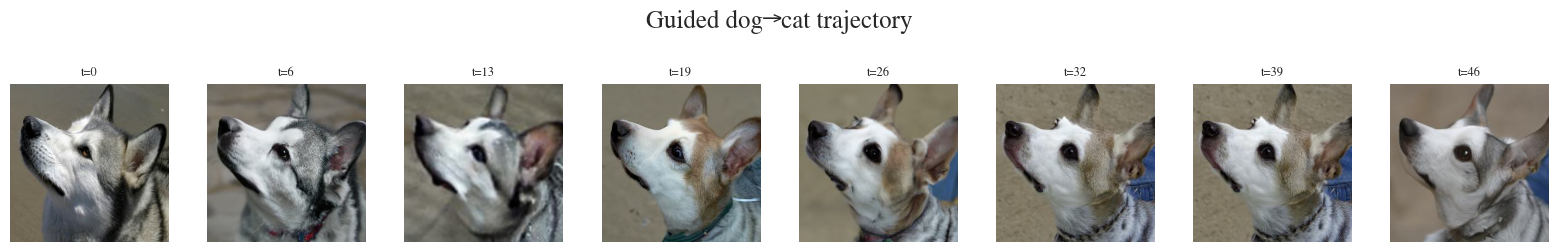

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039/plots/montage_unguided_force.pdf
Copied to exports: notebooks/_exports/montage_unguided_force.pdf


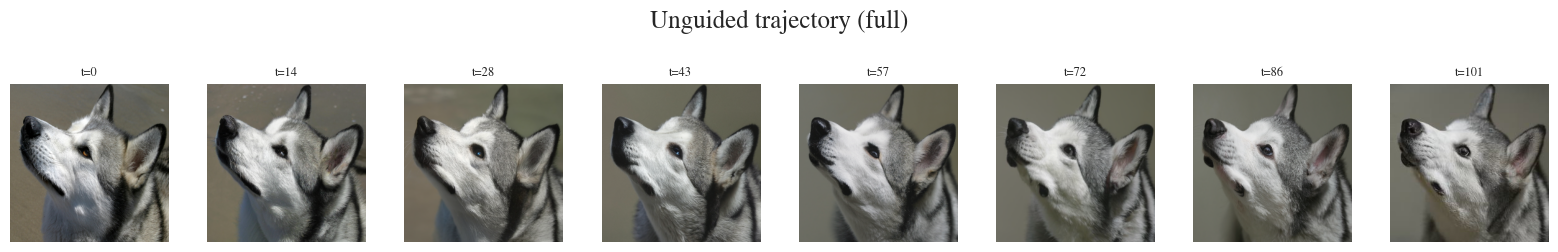

Guided top-10 (start):
   249  malamute                        p=0.3322
   248  Eskimo dog                      p=0.2548
   250  Siberian husky                  p=0.1015
   174  Norwegian elkhound              p=0.0178
   270  white wolf                      p=0.0084
   269  timber wolf                     p=0.0083
   273  dingo                           p=0.0034
   227  kelpie                          p=0.0020
   271  red wolf                        p=0.0018
   274  dhole                           p=0.0014
Guided top-10 (end):
   285  Egyptian cat                    p=0.4741
   151  Chihuahua                       p=0.0234
   264  Cardigan                        p=0.0215
   248  Eskimo dog                      p=0.0176
   273  dingo                           p=0.0126
   158  toy terrier                     p=0.0100
   227  kelpie                          p=0.0098
   171  Italian greyhound               p=0.0081
   172  whippet                         p=0.0070
   268  Mexican hairless 

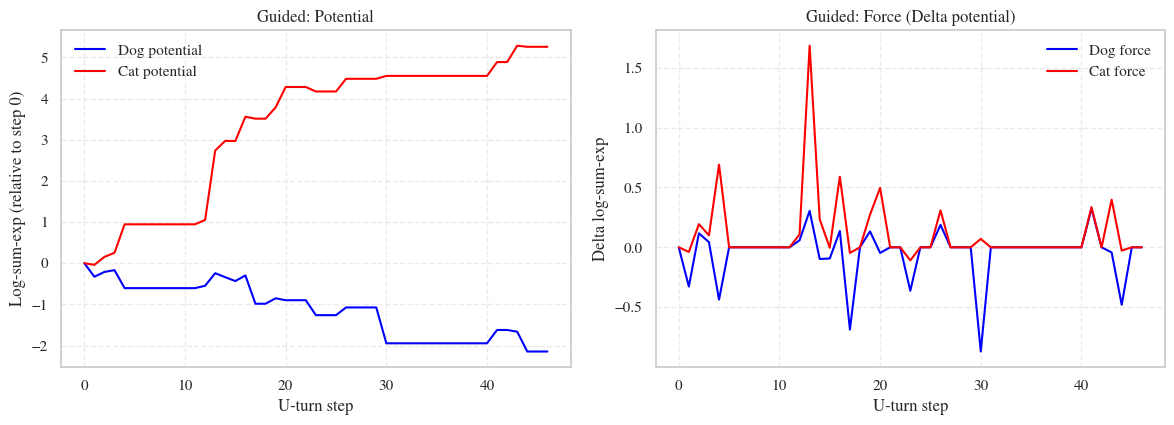

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039/plots/unguided_force_potential.pdf
Copied to exports: notebooks/_exports/unguided_force_potential.pdf


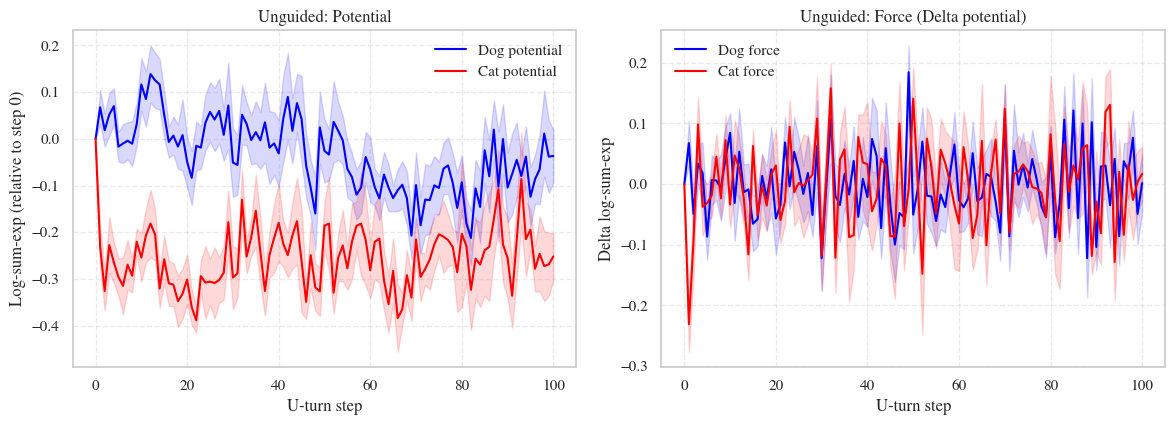

Guided probs (end): dog=0.1203, cat=0.5688
Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039/plots/guided_vs_unguided_prob_mass.pdf
Copied to exports: notebooks/_exports/guided_vs_unguided_prob_mass.pdf


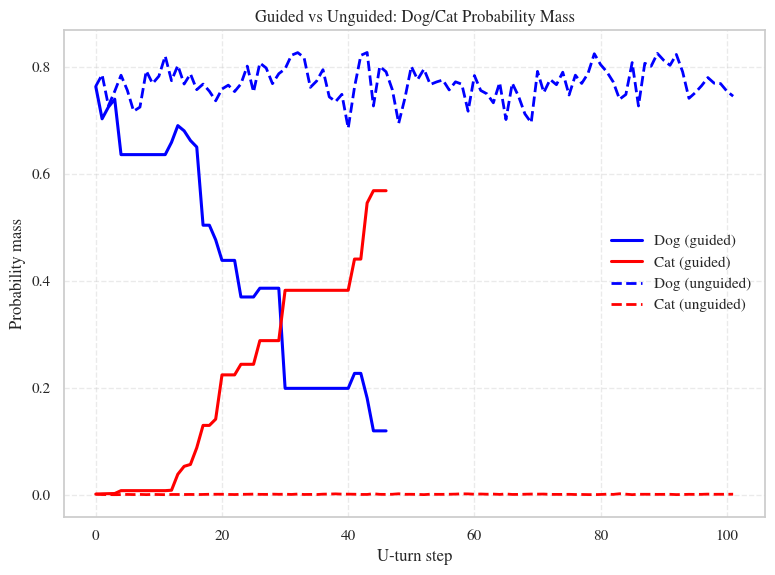

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0_run20260210-194039/plots/guided_force_stats_batch_cat_dog.pdf
Copied to exports: notebooks/_exports/guided_force_stats_batch_cat_dog.pdf


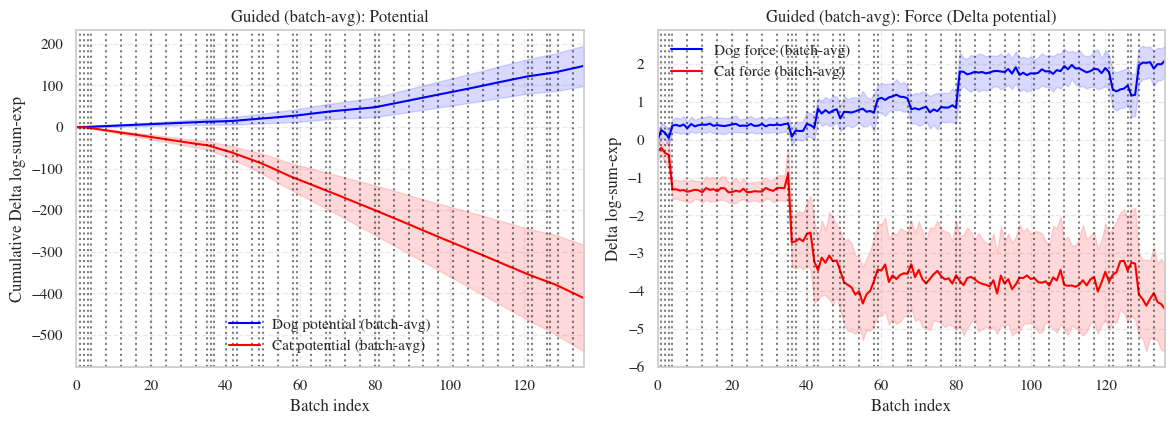

In [69]:
import os
import glob
import re
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from torchvision.transforms import Resize
import sys
from torchvision import transforms
from torchvision.models import ConvNeXt_Base_Weights

# --- PATH CONFIGURATION ---
PROJECT_ROOT = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion"
sys.path.insert(0, PROJECT_ROOT)

from guided_diffusion import dist_util
from guided_diffusion.torch_classifiers import load_classifier

sns.set_theme(style="whitegrid")
if "apply_pub_style" in globals():
    apply_pub_style()

# --- CONFIGURATION ---
GUIDED_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0"
AUTO_GUIDED_DIR = True
GUIDED_ROOT = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat"
UNGUIDED_DIR = "/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_100"

CLASSIFIER_NAME = "convnext_base"
IMAGE_SIZE = 256
MAX_STEPS = None
NORMALIZE_X = False  # show raw U-turn step by default

# Meta-class indices
DOG_INDICES = list(range(151, 269))
CAT_INDICES = list(range(281, 286))

# Averaging across trajectories
AVERAGE_GUIDED = False
AVERAGE_UNGUIDED = True
SYNC_UNGUIDED_TO_GUIDED_FORCE = False  # keep unguided full length
MAX_UNGUIDED_TRAJS = 10  # cap for speed

USE_STEERING_DATA_FOR_GUIDED = True  # prefer steering_data for guided probs/scores
STEERING_DATA_NAME = "steering_data.npz"
USE_FORCE_STATS_META = False  # optional: plot batch-based force_stats (combined score)
FORCE_STATS_NAME = "force_stats.npz"
EPS = 1e-8

POTENTIAL_MODE = "logits"  # "logits" (logsumexp) or "probs" (log prob)

FORCE_FROM_MEAN_POTENTIAL = False  # ensures force consistent with plotted potential
PLOT_GUIDED_FORCE_STATS = True  # use force_stats.npz (batch-averaged force)
PLOT_PROB_MASS = True  # reconstruct probability mass curves (dog vs cat)

# Montage (guided vs unguided)
MAKE_MONTAGE_FORCE = True
MONTAGE_FRAMES = 8

# Top-k prints
PRINT_TOPK_GUIDED = True
PRINT_TOPK_UNGUIDED = True
TOPK_K = 10

UNGUIDED_MANIFOLD_DIR = None  # e.g., /work/.../manifold_probe/ILSVRC.../probe_noise_50
MAX_MANIFOLD_TRAJS = 20
USE_MANIFOLD_FOR_PROB_MASS = True

USE_FORCE_STATS_STEP_AVG = False  # compute step-level force from batch stats

RELATIVE_TO_STEP0 = True   # subtract step 0 so potential starts at 0
SHADE_SEM = True

# --- HELPERS ---

def infer_latest_guided_dir(root, fallback=None):
    if root is None:
        return fallback
    cands = sorted(glob.glob(os.path.join(root, "noise_*_p*")))
    if not cands:
        return fallback
    # pick most recent by mtime
    return max(cands, key=os.path.getmtime)

# Auto-pick latest guided directory if requested
if AUTO_GUIDED_DIR:
    GUIDED_DIR = infer_latest_guided_dir(GUIDED_ROOT, fallback=GUIDED_DIR)
    if GUIDED_DIR is not None:
        print(f"Using GUIDED_DIR: {GUIDED_DIR}")

GUIDED_DIRS = [GUIDED_DIR]
OUTPUT_DIR = os.path.join(GUIDED_DIR, "plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)


def resolve_trajectory_dirs(base_dir, max_traj=None):
    traj_dirs = sorted(glob.glob(os.path.join(base_dir, "trajectory_*")))
    if traj_dirs:
        if max_traj is not None:
            traj_dirs = traj_dirs[:max_traj]
        return traj_dirs
    return [base_dir]


def list_images_with_steps(base_dir, patterns, regex, max_steps=None):
    if isinstance(patterns, str):
        patterns = [patterns]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir, pat)))
    items = []
    for f in files:
        m = re.search(regex, os.path.basename(f))
        if m:
            items.append((int(m.group(1)), f))
    items = sorted(items, key=lambda x: x[0])
    if max_steps is not None:
        items = [it for it in items if it[0] <= max_steps]
    return [p for _, p in items]


def normalize_x(n):
    if n <= 1:
        return np.arange(n)
    return np.linspace(0, 1, n) if NORMALIZE_X else np.arange(n)


def maybe_export(path):
    if "export_to_notebook_dir" in globals():
        export_to_notebook_dir(path)
        return
    export_dir = os.path.join("notebooks", "_exports")
    os.makedirs(export_dir, exist_ok=True)
    dst = os.path.join(export_dir, os.path.basename(path))
    try:
        import shutil
        shutil.copy(path, dst)
        print(f"Copied to exports: {dst}")
    except Exception as e:
        print(f"Export failed: {e}")


def sample_indices(n, num_samples):
    if n <= num_samples:
        return list(range(n))
    return list(np.linspace(0, n - 1, num_samples, dtype=int))


def make_montage(image_paths, title, out_path):
    if not image_paths:
        print(f"No images for montage: {title}")
        return
    idxs = sample_indices(len(image_paths), MONTAGE_FRAMES)
    fig, axes = plt.subplots(1, len(idxs), figsize=(2.0 * len(idxs), 2.5))
    if len(idxs) == 1:
        axes = [axes]
    for ax, i in zip(axes, idxs):
        img = Image.open(image_paths[i]).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"t={i}", fontsize=9)
        ax.axis("off")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()


def topk_from_logits(logits, k=10):
    probs = th.softmax(logits, dim=1)[0]
    vals, idxs = th.topk(probs, k)
    return [(int(i), float(v)) for i, v in zip(idxs.cpu(), vals.cpu())]


def load_classifier_model():
    dist_util.setup_dist()
    device = dist_util.dev()
    classifier, preprocess, _ = load_classifier(CLASSIFIER_NAME)
    classifier.to(device).eval()
    return classifier, preprocess, device


def collect_logits(image_paths, classifier, preprocess, device):
    resize = Resize([IMAGE_SIZE, IMAGE_SIZE], Image.BICUBIC)
    all_logits = []
    for p in image_paths:
        img = Image.open(p).convert("RGB")
        img = resize(img)
        arr = np.array(img).astype(np.float32) / 127.5 - 1.0
        batch = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
        with th.no_grad():
            logits = classifier(preprocess(batch))
        all_logits.append(logits.detach().cpu()[0])
    return th.stack(all_logits, dim=0) if all_logits else None


def meta_scores_from_logits(logits_tensor):
    # logits_tensor: [T, 1000]
    dog = th.logsumexp(logits_tensor[:, DOG_INDICES], dim=1).cpu().numpy()
    cat = th.logsumexp(logits_tensor[:, CAT_INDICES], dim=1).cpu().numpy()
    return dog, cat


def meta_probs_from_logits(logits_tensor):
    probs = th.softmax(logits_tensor, dim=1)
    dog = probs[:, DOG_INDICES].sum(dim=1).cpu().numpy()
    cat = probs[:, CAT_INDICES].sum(dim=1).cpu().numpy()
    return dog, cat


def potentials_from_probs(probs, relative=True):
    probs = np.clip(np.array(probs, dtype=float), EPS, 1.0)
    pot = np.log(probs)
    if relative and len(pot) > 0:
        pot = pot - pot[0]
    force = np.diff(pot, prepend=pot[0])
    return pot, force


def potentials_and_forces(scores, relative=True):
    scores = np.array(scores, dtype=float)
    if relative and len(scores) > 0:
        scores = scores - scores[0]
    force = np.diff(scores, prepend=scores[0])
    return scores, force


def average_series(series_list):
    if not series_list:
        return None, None
    min_len = min(len(s) for s in series_list)
    arr = np.stack([np.array(s[:min_len]) for s in series_list], axis=0)
    mean = arr.mean(axis=0)
    sem = arr.std(axis=0) / np.sqrt(arr.shape[0]) if arr.shape[0] > 1 else None
    return mean, sem


def load_force_stats(gdir):
    fpath = os.path.join(gdir, FORCE_STATS_NAME)
    if not os.path.exists(fpath):
        return None
    data = np.load(fpath)
    out = {"force": data["force"]}
    if "force_cat" in data:
        out["force_cat"] = data["force_cat"]
    if "force_dog" in data:
        out["force_dog"] = data["force_dog"]
    return out


def load_attempts(gdir):
    fpath = os.path.join(gdir, STEERING_DATA_NAME)
    if not os.path.exists(fpath):
        return None
    data = np.load(fpath)
    return data.get("attempts", None)


def load_manifold_logits(base_dir, max_traj=None):
    if base_dir is None:
        return None
    files = sorted(glob.glob(os.path.join(base_dir, "traj_*", "manifold_logits.npz")))
    if not files:
        return None
    if max_traj is not None:
        files = files[:max_traj]
    logits_list = []
    for f in files:
        data = np.load(f)["logits"]
        logits_list.append(data)
    try:
        return np.stack(logits_list, axis=0)  # [N, T, 1000]
    except Exception:
        return None


def force_stats_to_steps(force_hist, attempts):
    if force_hist is None or attempts is None:
        return None, None, None
    attempts = np.array(attempts, dtype=int)
    nz = attempts[attempts > 0]
    if len(nz) == 0:
        return None, None, None
    batch_size = int(np.gcd.reduce(nz))
    batches_per_step = (attempts / batch_size).astype(int)
    # skip step 0
    means = []
    sems = []
    idx = 0
    for step_idx, nb in enumerate(batches_per_step):
        if step_idx == 0:
            continue
        if nb <= 0:
            break
        seg = force_hist[idx:idx+nb, 0]
        if len(seg) == 0:
            break
        means.append(seg.mean())
        sems.append(seg.std() / np.sqrt(len(seg)) if len(seg) > 1 else 0.0)
        idx += nb
    pot = np.cumsum(means) if len(means) > 0 else None
    return np.array(means), np.array(sems), pot


def steering_len_from_data(gdir):
    fpath = os.path.join(gdir, STEERING_DATA_NAME)
    if not os.path.exists(fpath):
        return None
    data = np.load(fpath)
    for key in ("probs_cat", "probs_target", "probs_dog", "probs_orig", "scores", "cat_scores", "dog_scores"):
        if key in data:
            return len(data[key])
    return None


def guided_probs_from_data(data):
    if "probs_cat" in data and "probs_dog" in data:
        return data["probs_dog"], data["probs_cat"]
    if "probs_orig" in data and "probs_target" in data:
        return data["probs_orig"], data["probs_target"]
    return None, None


def guided_scores_from_data(data):
    if "dog_scores" in data and "cat_scores" in data:
        return data["dog_scores"], data["cat_scores"]
    return None, None


def print_topk_pair(label, logits):
    if logits is None or len(logits) == 0:
        return
    weights = ConvNeXt_Base_Weights.DEFAULT
    categories = weights.meta.get("categories", None)
    top_start = topk_from_logits(logits[0:1], k=TOPK_K)
    top_end = topk_from_logits(logits[-1:].clone(), k=TOPK_K)
    print(f"{label} top-{TOPK_K} (start):")
    for idx, val in top_start:
        name = categories[idx] if categories is not None else str(idx)
        print(f"  {idx:4d}  {name:30s}  p={val:.4f}")
    print(f"{label} top-{TOPK_K} (end):")
    for idx, val in top_end:
        name = categories[idx] if categories is not None else str(idx)
        print(f"  {idx:4d}  {name:30s}  p={val:.4f}")


classifier, preprocess, device = load_classifier_model()

# --- 1) Collect guided trajectories ---
all_guided_logs = []
for gdir in GUIDED_DIRS:
    guided_images = list_images_with_steps(gdir, ["step_*.jpeg", "step_*.png"], r"step_(\d+)\.(jpeg|png)", MAX_STEPS)
    if guided_images:
        all_guided_logs.append((gdir, guided_images))
    else:
        print(f"No guided images found in {gdir}")

# --- 2) Collect unguided trajectories ---
all_unguided_logs = []
for udir in resolve_trajectory_dirs(UNGUIDED_DIR, MAX_UNGUIDED_TRAJS if AVERAGE_UNGUIDED else 1):
    unguided_images = list_images_with_steps(udir, ["uturn_*.jpeg", "uturn_*.png"], r"uturn_(\d+)\.(jpeg|png)", MAX_STEPS)
    if unguided_images:
        all_unguided_logs.append(unguided_images)
    else:
        print(f"No unguided images found in {udir}")

# --- Truncate guided image lists to match steering_data length (avoid mixing old steps) ---
force_guided_len_ref = None
for idx, (gdir, gimgs) in enumerate(all_guided_logs):
    n = steering_len_from_data(gdir)
    if n is not None:
        filt = []
        for p in gimgs:
            m = re.search(r"step_(\d+)", os.path.basename(p))
            if m and int(m.group(1)) < n:
                filt.append(p)
        all_guided_logs[idx] = (gdir, filt)
        force_guided_len_ref = n if force_guided_len_ref is None else min(force_guided_len_ref, n)

# Optionally sync unguided to guided length
if SYNC_UNGUIDED_TO_GUIDED_FORCE and force_guided_len_ref is not None:
    for j in range(len(all_unguided_logs)):
        filt = []
        for p in all_unguided_logs[j]:
            m = re.search(r"uturn_(\d+)", os.path.basename(p))
            if m and int(m.group(1)) < force_guided_len_ref:
                filt.append(p)
        all_unguided_logs[j] = filt

print(f"Guided trajectories: {len(all_guided_logs)}")
print(f"Unguided trajectories: {len(all_unguided_logs)}")

# --- Montage for force/potential cell ---
if MAKE_MONTAGE_FORCE and all_guided_logs:
    gdir, gimgs = all_guided_logs[0]
    out_path = os.path.join(OUTPUT_DIR, "montage_guided_force.pdf")
    make_montage(gimgs, "Guided dog→cat trajectory", out_path)
if MAKE_MONTAGE_FORCE and all_unguided_logs:
    uimgs = all_unguided_logs[0]
    out_path = os.path.join(OUTPUT_DIR, "montage_unguided_force.pdf")
    make_montage(uimgs, "Unguided trajectory (full)", out_path)

# --- Top-10 classes (start vs end) ---
if PRINT_TOPK_GUIDED and all_guided_logs:
    gdir, gimgs = all_guided_logs[0]
    logits_g = collect_logits(gimgs, classifier, preprocess, device)
    if logits_g is not None:
        print_topk_pair("Guided", logits_g)

if PRINT_TOPK_UNGUIDED and all_unguided_logs:
    logits_u = collect_logits(all_unguided_logs[0], classifier, preprocess, device)
    if logits_u is not None:
        print_topk_pair("Unguided", logits_u)

# --- 3) Compute potentials/forces per trajectory ---

def compute_for_trajectories(image_lists):
    dog_pots = []
    dog_forces = []
    cat_pots = []
    cat_forces = []
    for imgs in image_lists:
        logits = collect_logits(imgs, classifier, preprocess, device)
        if logits is None:
            continue
        if POTENTIAL_MODE == "probs":
            dog_probs, cat_probs = meta_probs_from_logits(logits)
            dog_pot, dog_force = potentials_from_probs(dog_probs, RELATIVE_TO_STEP0)
            cat_pot, cat_force = potentials_from_probs(cat_probs, RELATIVE_TO_STEP0)
        else:
            dog_scores, cat_scores = meta_scores_from_logits(logits)
            dog_pot, dog_force = potentials_and_forces(dog_scores, RELATIVE_TO_STEP0)
            cat_pot, cat_force = potentials_and_forces(cat_scores, RELATIVE_TO_STEP0)
        dog_pots.append(dog_pot)
        dog_forces.append(dog_force)
        cat_pots.append(cat_pot)
        cat_forces.append(cat_force)
    return dog_pots, dog_forces, cat_pots, cat_forces


guided_dog_pots = []
guided_dog_forces = []
guided_cat_pots = []
guided_cat_forces = []

# Guided: use steering_data.npz if requested
if USE_STEERING_DATA_FOR_GUIDED:
    for gdir, _ in all_guided_logs:
        data_file = os.path.join(gdir, STEERING_DATA_NAME)
        if os.path.exists(data_file):
            data = np.load(data_file)
            if POTENTIAL_MODE == "probs":
                probs_dog, probs_cat = guided_probs_from_data(data)
                if probs_dog is not None:
                    pot_dog, force_dog = potentials_from_probs(probs_dog, RELATIVE_TO_STEP0)
                    pot_cat, force_cat = potentials_from_probs(probs_cat, RELATIVE_TO_STEP0)
                else:
                    pot_dog = pot_cat = force_dog = force_cat = None
            else:
                scores_dog, scores_cat = guided_scores_from_data(data)
                if scores_dog is not None:
                    pot_dog, force_dog = potentials_and_forces(scores_dog, RELATIVE_TO_STEP0)
                    pot_cat, force_cat = potentials_and_forces(scores_cat, RELATIVE_TO_STEP0)
                else:
                    pot_dog = pot_cat = force_dog = force_cat = None
            if pot_dog is not None:
                guided_dog_pots.append(pot_dog)
                guided_dog_forces.append(force_dog)
                guided_cat_pots.append(pot_cat)
                guided_cat_forces.append(force_cat)
        else:
            print(f"No steering_data.npz in {gdir}; falling back to logits.")

# Fallback to logits if not using steering_data (or if none loaded)
if (not USE_STEERING_DATA_FOR_GUIDED) or (len(guided_dog_pots) == 0):
    guided_image_lists = [imgs for _, imgs in all_guided_logs]
    gd_p, gd_f, gc_p, gc_f = compute_for_trajectories(guided_image_lists)
    guided_dog_pots = gd_p
    guided_dog_forces = gd_f
    guided_cat_pots = gc_p
    guided_cat_forces = gc_f

unguided_dog_pots, unguided_dog_forces, unguided_cat_pots, unguided_cat_forces = compute_for_trajectories(all_unguided_logs)

# --- 4) Average if requested ---

def prepare_plot_data(pots, forces, average):
    if average and len(pots) > 1:
        pot_mean, pot_sem = average_series(pots)
        force_mean, force_sem = average_series(forces)
        return pot_mean, pot_sem, force_mean, force_sem
    else:
        pot = pots[0] if pots else None
        force = forces[0] if forces else None
        return pot, None, force, None


g_dog_pot, g_dog_pot_sem, g_dog_force, g_dog_force_sem = prepare_plot_data(guided_dog_pots, guided_dog_forces, AVERAGE_GUIDED)

g_cat_pot, g_cat_pot_sem, g_cat_force, g_cat_force_sem = prepare_plot_data(guided_cat_pots, guided_cat_forces, AVERAGE_GUIDED)

u_dog_pot, u_dog_pot_sem, u_dog_force, u_dog_force_sem = prepare_plot_data(unguided_dog_pots, unguided_dog_forces, AVERAGE_UNGUIDED)

u_cat_pot, u_cat_pot_sem, u_cat_force, u_cat_force_sem = prepare_plot_data(unguided_cat_pots, unguided_cat_forces, AVERAGE_UNGUIDED)

# --- 5) Plot guided ---
if g_dog_pot is not None:
    x = normalize_x(len(g_dog_pot))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

    ax1.plot(x, g_dog_pot, color="blue", label="Dog potential")
    ax1.plot(x, g_cat_pot, color="red", label="Cat potential")
    if SHADE_SEM and g_dog_pot_sem is not None:
        ax1.fill_between(x, g_dog_pot - g_dog_pot_sem, g_dog_pot + g_dog_pot_sem, color="blue", alpha=0.15)
    if SHADE_SEM and g_cat_pot_sem is not None:
        ax1.fill_between(x, g_cat_pot - g_cat_pot_sem, g_cat_pot + g_cat_pot_sem, color="red", alpha=0.15)

    ax1.set_title("Guided: Potential")
    ax1.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax1.set_ylabel("Log prob (relative to step 0)" if (POTENTIAL_MODE=="probs" and RELATIVE_TO_STEP0) else ("Log prob" if POTENTIAL_MODE=="probs" else ("Log-sum-exp (relative to step 0)" if RELATIVE_TO_STEP0 else "Log-sum-exp")))
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.4)

    ax2.plot(x, g_dog_force, color="blue", label="Dog force")
    ax2.plot(x, g_cat_force, color="red", label="Cat force")
    if SHADE_SEM and g_dog_force_sem is not None:
        ax2.fill_between(x, g_dog_force - g_dog_force_sem, g_dog_force + g_dog_force_sem, color="blue", alpha=0.15)
    if SHADE_SEM and g_cat_force_sem is not None:
        ax2.fill_between(x, g_cat_force - g_cat_force_sem, g_cat_force + g_cat_force_sem, color="red", alpha=0.15)

    ax2.set_title("Guided: Force (Delta potential)")
    ax2.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax2.set_ylabel("Delta log prob" if POTENTIAL_MODE=="probs" else "Delta log-sum-exp")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "guided_force_potential.pdf")
    plt.savefig(out_path, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()

# --- 6) Plot unguided ---
if u_dog_pot is not None:
    x = normalize_x(len(u_dog_pot))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

    ax1.plot(x, u_dog_pot, color="blue", label="Dog potential")
    ax1.plot(x, u_cat_pot, color="red", label="Cat potential")
    if SHADE_SEM and u_dog_pot_sem is not None:
        ax1.fill_between(x, u_dog_pot - u_dog_pot_sem, u_dog_pot + u_dog_pot_sem, color="blue", alpha=0.15)
    if SHADE_SEM and u_cat_pot_sem is not None:
        ax1.fill_between(x, u_cat_pot - u_cat_pot_sem, u_cat_pot + u_cat_pot_sem, color="red", alpha=0.15)

    ax1.set_title("Unguided: Potential")
    ax1.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax1.set_ylabel("Log prob (relative to step 0)" if (POTENTIAL_MODE=="probs" and RELATIVE_TO_STEP0) else ("Log prob" if POTENTIAL_MODE=="probs" else ("Log-sum-exp (relative to step 0)" if RELATIVE_TO_STEP0 else "Log-sum-exp")))
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.4)

    ax2.plot(x, u_dog_force, color="blue", label="Dog force")
    ax2.plot(x, u_cat_force, color="red", label="Cat force")
    if SHADE_SEM and u_dog_force_sem is not None:
        ax2.fill_between(x, u_dog_force - u_dog_force_sem, u_dog_force + u_dog_force_sem, color="blue", alpha=0.15)
    if SHADE_SEM and u_cat_force_sem is not None:
        ax2.fill_between(x, u_cat_force - u_cat_force_sem, u_cat_force + u_cat_force_sem, color="red", alpha=0.15)

    ax2.set_title("Unguided: Force (Delta potential)")
    ax2.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax2.set_ylabel("Delta log prob" if POTENTIAL_MODE=="probs" else "Delta log-sum-exp")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "unguided_force_potential.pdf")
    plt.savefig(out_path, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()

# --- 7) Reconstruct probability mass curves (dog vs cat) ---
if PLOT_PROB_MASS:
    # guided probabilities
    guided_probs_dog = None
    guided_probs_cat = None
    if USE_STEERING_DATA_FOR_GUIDED:
        for gdir, _ in all_guided_logs:
            fpath = os.path.join(gdir, STEERING_DATA_NAME)
            if os.path.exists(fpath):
                data = np.load(fpath)
                guided_probs_dog, guided_probs_cat = guided_probs_from_data(data)
                break
    if guided_probs_dog is None and len(all_guided_logs) > 0:
        # compute from logits of guided images
        guided_image_lists = [imgs for _, imgs in all_guided_logs]
        logits = collect_logits(guided_image_lists[0], classifier, preprocess, device)
        if logits is not None:
            guided_probs_dog, guided_probs_cat = meta_probs_from_logits(logits)

    # unguided probabilities (prefer manifold logits if available)
    unguided_probs_dog = None
    unguided_probs_cat = None
    if USE_MANIFOLD_FOR_PROB_MASS and UNGUIDED_MANIFOLD_DIR is not None:
        logits_stack = load_manifold_logits(UNGUIDED_MANIFOLD_DIR, MAX_MANIFOLD_TRAJS)
        if logits_stack is not None:
            # logits_stack: [N, T, 1000]
            probs = th.softmax(th.tensor(logits_stack), dim=2).numpy()
            dog = probs[:, :, DOG_INDICES].sum(axis=2)
            cat = probs[:, :, CAT_INDICES].sum(axis=2)
            unguided_probs_dog = dog.mean(axis=0)
            unguided_probs_cat = cat.mean(axis=0)
    if unguided_probs_dog is None and len(all_unguided_logs) > 0:
        logits = collect_logits(all_unguided_logs[0], classifier, preprocess, device)
        if logits is not None:
            unguided_probs_dog, unguided_probs_cat = meta_probs_from_logits(logits)

    if guided_probs_dog is not None:
        print(f"Guided probs (end): dog={guided_probs_dog[-1]:.4f}, cat={guided_probs_cat[-1]:.4f}")

    if guided_probs_dog is not None and unguided_probs_dog is not None:
        xg = normalize_x(len(guided_probs_dog))
        xu = normalize_x(len(unguided_probs_dog))
        plt.figure(figsize=(8, 6))
        plt.plot(xg, guided_probs_dog, color="blue", linewidth=2.2, label="Dog (guided)")
        plt.plot(xg, guided_probs_cat, color="red", linewidth=2.2, label="Cat (guided)")
        plt.plot(xu, unguided_probs_dog, color="blue", linestyle="--", linewidth=2.0, label="Dog (unguided)")
        plt.plot(xu, unguided_probs_cat, color="red", linestyle="--", linewidth=2.0, label="Cat (unguided)")
        plt.xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
        plt.ylabel("Probability mass")
        plt.title("Guided vs Unguided: Dog/Cat Probability Mass")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, "guided_vs_unguided_prob_mass.pdf")
        plt.savefig(out_path, bbox_inches="tight")
        print(f"Saved: {out_path}")
        maybe_export(out_path)
        plt.show()
    else:
        print("Could not reconstruct probability mass curves (missing data).")

# --- 5b) Guided: batch-averaged force_stats (per batch, includes rejected steps) ---
if PLOT_GUIDED_FORCE_STATS and len(all_guided_logs) > 0:
    gdir, _ = all_guided_logs[0]
    stats = load_force_stats(gdir)
    attempts = load_attempts(gdir)
    if stats is not None:
        if "force_cat" in stats and "force_dog" in stats:
            cat_force = stats["force_cat"][:, 0]
            cat_std = stats["force_cat"][:, 1]
            dog_force = stats["force_dog"][:, 0]
            dog_std = stats["force_dog"][:, 1]
            cat_pot = np.cumsum(cat_force)
            dog_pot = np.cumsum(dog_force)
            cat_pot_std = np.cumsum(cat_std)
            dog_pot_std = np.cumsum(dog_std)
            x = np.arange(len(cat_force))

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
            ax1.plot(x, dog_pot, color="blue", label="Dog potential (batch-avg)")
            ax1.plot(x, cat_pot, color="red", label="Cat potential (batch-avg)")
            ax1.fill_between(x, dog_pot - dog_pot_std, dog_pot + dog_pot_std, color="blue", alpha=0.15)
            ax1.fill_between(x, cat_pot - cat_pot_std, cat_pot + cat_pot_std, color="red", alpha=0.15)
            ax1.set_title("Guided (batch-avg): Potential")
            ax1.set_xlabel("Batch index")
            ax1.set_ylabel("Cumulative Delta log-sum-exp")
            ax1.legend()
            ax1.grid(True, linestyle="--", alpha=0.4)

            ax2.plot(x, dog_force, color="blue", label="Dog force (batch-avg)")
            ax2.plot(x, cat_force, color="red", label="Cat force (batch-avg)")
            ax2.fill_between(x, dog_force - dog_std, dog_force + dog_std, color="blue", alpha=0.15)
            ax2.fill_between(x, cat_force - cat_std, cat_force + cat_std, color="red", alpha=0.15)
            ax2.set_title("Guided (batch-avg): Force (Delta potential)")
            ax2.set_xlabel("Batch index")
            ax2.set_ylabel("Delta log-sum-exp")
            ax2.legend()
            ax2.grid(True, linestyle="--", alpha=0.4)

            for ax in (ax1, ax2):
                ax.set_xlim(0, len(x) - 1)

            # Optional: overlay step boundaries using attempts
            if attempts is not None:
                attempts = np.array(attempts, dtype=int)
                nz = attempts[attempts > 0]
                batch_size = int(np.gcd.reduce(nz)) if len(nz) > 0 else None
                cumulative = 0
                for i, count in enumerate(attempts):
                    if i == 0:
                        continue
                    if count == 0:
                        break
                    cumulative += int(count)
                    if batch_size is not None and batch_size > 0:
                        xline = cumulative / batch_size
                    else:
                        xline = cumulative
                    ax1.axvline(xline, color="black", linestyle=":", alpha=0.5)
                    ax2.axvline(xline, color="black", linestyle=":", alpha=0.5)

            plt.tight_layout()
            out_path = os.path.join(OUTPUT_DIR, "guided_force_stats_batch_cat_dog.pdf")
            plt.savefig(out_path, bbox_inches="tight")
            print(f"Saved: {out_path}")
            maybe_export(out_path)
            plt.show()
        else:
            # Fallback to combined score if cat/dog stats not available
            force_hist = stats["force"]
            mean_force = force_hist[:, 0]
            std_force = force_hist[:, 1]
            pot = np.cumsum(mean_force)
            x = np.arange(len(mean_force))

            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
            ax1.plot(x, mean_force, color="purple", label="Mean force (batch)")
            ax1.fill_between(x, mean_force - std_force, mean_force + std_force, color="purple", alpha=0.15)
            ax1.axhline(0, color="gray", linestyle="--", linewidth=1)
            ax1.set_ylabel("Force (batch mean Delta score)")
            ax1.set_title("Guided: Force from batch stats (per batch)")
            ax1.legend()
            ax1.grid(True, linestyle="--", alpha=0.4)

            ax2.plot(x, pot, color="darkorange", label="Potential (cumsum)")
            ax2.set_ylabel("Potential")
            ax2.set_xlabel("Batch index")
            ax1.set_xlim(0, len(mean_force)-1)
            ax2.set_xlim(0, len(mean_force)-1)
            ax2.legend()
            ax2.grid(True, linestyle="--", alpha=0.4)

            # Optional: overlay step boundaries using attempts
            if attempts is not None:
                attempts = np.array(attempts, dtype=int)
                nz = attempts[attempts > 0]
                batch_size = int(np.gcd.reduce(nz)) if len(nz) > 0 else None
                cumulative = 0
                for i, count in enumerate(attempts):
                    if i == 0:
                        continue
                    if count == 0:
                        break
                    cumulative += int(count)
                    if batch_size is not None and batch_size > 0:
                        xline = cumulative / batch_size
                    else:
                        xline = cumulative
                    ax1.axvline(xline, color="black", linestyle=":", alpha=0.5)
                    ax2.axvline(xline, color="black", linestyle=":", alpha=0.5)

            plt.tight_layout()
            out_path = os.path.join(OUTPUT_DIR, "guided_force_stats_batch.pdf")
            plt.savefig(out_path, bbox_inches="tight")
            print(f"Saved: {out_path}")
            maybe_export(out_path)
            plt.show()
    else:
        print("No force_stats.npz found for guided run.")


In [29]:
print(f"Guided probs (end): dog={guided_probs_dog[-1]:.4f},cat={guided_probs_cat[-1]:.4f}")

Guided probs (end): dog=0.7397,cat=0.0033


In [30]:
data = np.load(os.path.join(GUIDED_DIR, "steering_data.npz"))
print("probs_cat:", data["probs_cat"])
print("monotonic:", np.all(np.diff(data["probs_cat"]) >= -1e-8))

probs_cat: [0.0022049  0.00271606 0.00301361 0.00325966 0.0086441 ]
monotonic: True


## Guided vs Unguided (Dog→Dog) Force/Potential

This mirrors the dog→cat analysis but compares two specific dog classes (orig→target).
The guided run auto-selects the target dog class and saves `auto_target.json`.


Using GUIDED_DIR: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044
Auto-target: orig=249, target=248
Guided trajectories: 1
Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044/plots/montage_guided_dog2dog.pdf


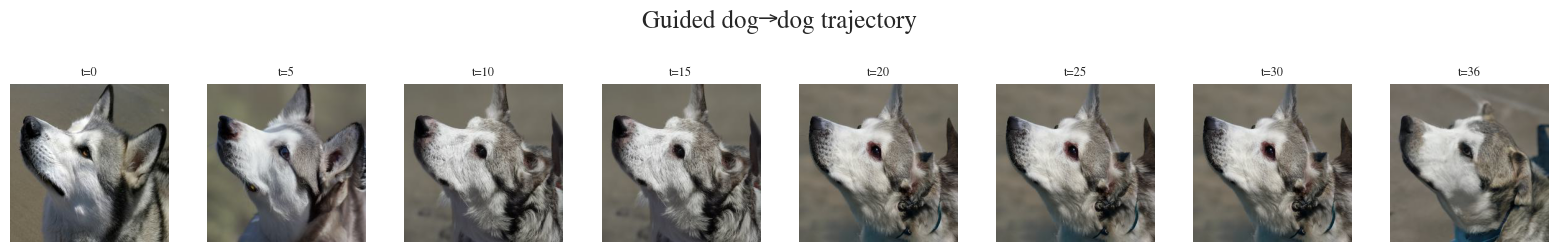

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044/plots/montage_unguided_dog2dog.pdf


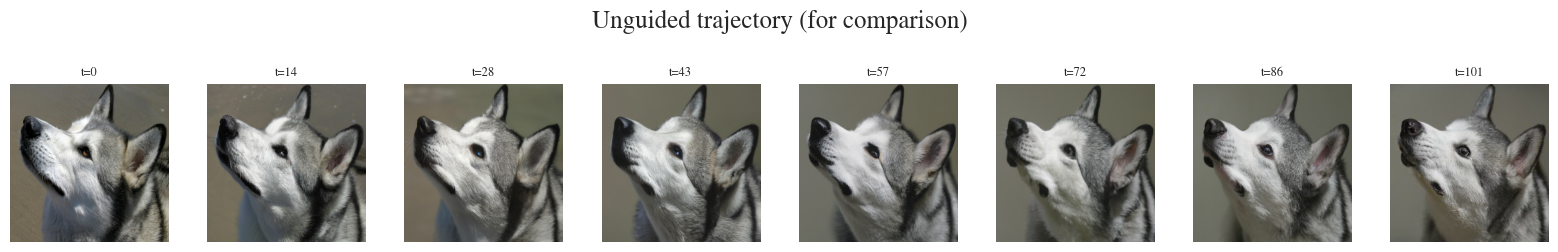

Unguided trajectories: 10
Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044/plots/guided_dog2dog_force_potential.pdf


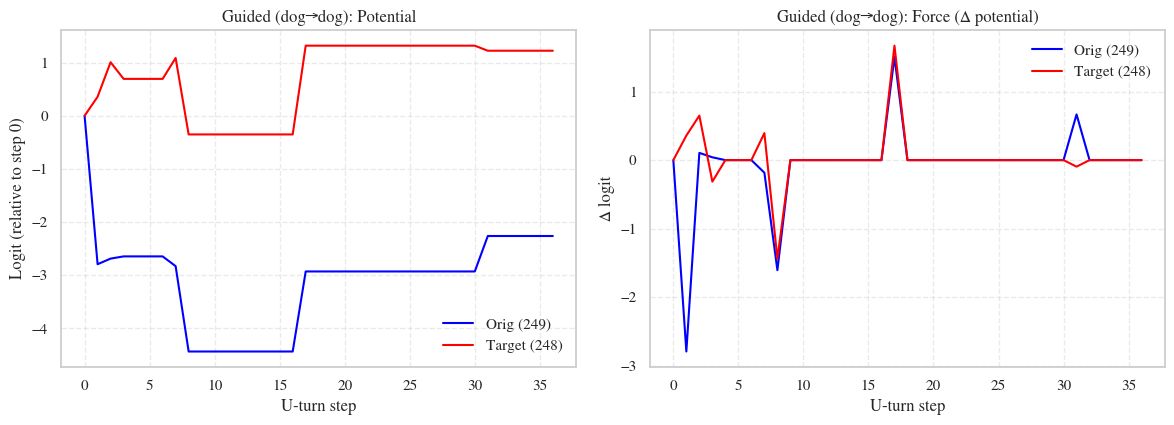

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044/plots/unguided_dog2dog_force_potential.pdf


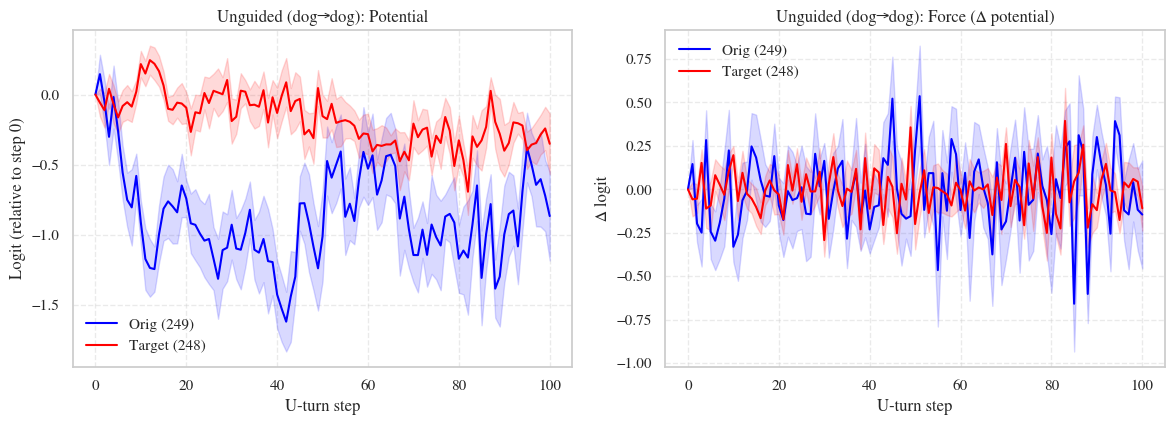

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044/plots/guided_vs_unguided_dog2dog_prob_mass.pdf


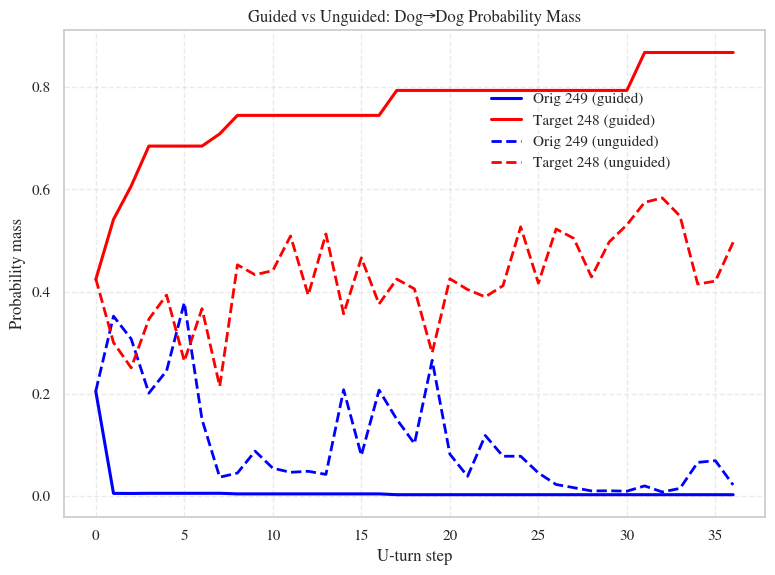

Saved: /work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729/target_auto_248/noise_100_p1.0_b64_r4_run20260210-194044/plots/guided_dog2dog_force_stats_batch.pdf


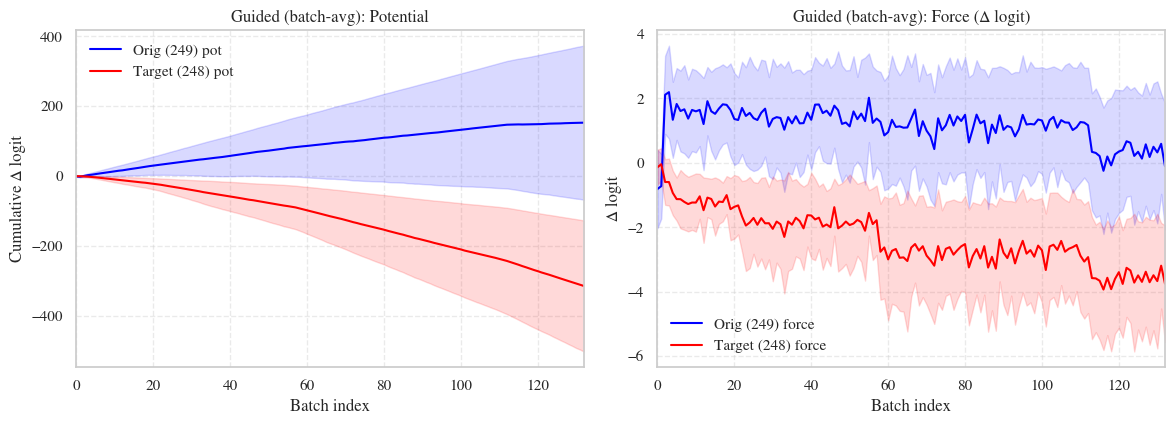

In [68]:
import os
import glob
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from torchvision.transforms import Resize

sns.set_theme(style="whitegrid")
if "apply_pub_style" in globals():
    apply_pub_style()

# --- CONFIGURATION ---
GUIDED_ROOT = "/work/pcsl/Noam/sequential_diffusion/results/steering_dog2dog_v1/ILSVRC2012_val_00000729"
UNGUIDED_DIR = "/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_100"

CLASSIFIER_NAME = "convnext_base"
IMAGE_SIZE = 256
MAX_STEPS = None
NORMALIZE_X = False

# Averaging across trajectories
AVERAGE_GUIDED = False
AVERAGE_UNGUIDED = True
MAX_UNGUIDED_TRAJS = 10

# Montage (horizontal)
MAKE_MONTAGE_DOG2DOG = True
MONTAGE_FRAMES = 8

def sample_indices(n, num_samples):
    if n <= num_samples:
        return list(range(n))
    return list(np.linspace(0, n - 1, num_samples, dtype=int))

def make_montage(image_paths, title, out_path):
    if not image_paths:
        print(f"No images for montage: {title}")
        return
    idxs = sample_indices(len(image_paths), MONTAGE_FRAMES)
    fig, axes = plt.subplots(1, len(idxs), figsize=(2. * len(idxs), 2.5))
    if len(idxs) == 1:
        axes = [axes]
    for ax, i in zip(axes, idxs):
        img = Image.open(image_paths[i]).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"t={i}", fontsize=9)
        ax.axis("off")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")
    if 'export_to_notebook_dir' in globals():
        export_to_notebook_dir(out_path)
    plt.show()

POTENTIAL_MODE = "logits"  # "logits" or "probs"
RELATIVE_TO_STEP0 = True
SHADE_SEM = True

# Optional: batch stats from steering (accepted + rejected)
PLOT_GUIDED_FORCE_STATS = True
FORCE_STATS_NAME = "force_stats.npz"
STEERING_DATA_NAME = "steering_data.npz"

# --- HELPERS ---

def maybe_export(path):
    if "export_to_notebook_dir" in globals():
        export_to_notebook_dir(path)
        return
    export_dir = os.path.join("notebooks", "_exports")
    os.makedirs(export_dir, exist_ok=True)
    try:
        import shutil
        shutil.copy(path, os.path.join(export_dir, os.path.basename(path)))
    except Exception:
        pass


def resolve_trajectory_dirs(base_dir, max_traj=None):
    traj_dirs = sorted(glob.glob(os.path.join(base_dir, "trajectory_*")))
    if traj_dirs:
        if max_traj is not None:
            traj_dirs = traj_dirs[:max_traj]
        return traj_dirs
    return [base_dir]


def list_images_with_steps(base_dir, patterns, regex, max_steps=None):
    if isinstance(patterns, str):
        patterns = [patterns]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir, pat)))
    items = []
    for f in files:
        import re
        m = re.search(regex, os.path.basename(f))
        if m:
            items.append((int(m.group(1)), f))
    items = sorted(items, key=lambda x: x[0])
    if max_steps is not None:
        items = [it for it in items if it[0] <= max_steps]
    return [p for _, p in items]


def normalize_x(n):
    if n <= 1:
        return np.arange(n)
    return np.linspace(0, 1, n) if NORMALIZE_X else np.arange(n)


def collect_logits(image_paths, classifier, preprocess, device):
    resize = Resize([IMAGE_SIZE, IMAGE_SIZE], Image.BICUBIC)
    all_logits = []
    for p in image_paths:
        img = Image.open(p).convert("RGB")
        img = resize(img)
        arr = np.array(img).astype(np.float32) / 127.5 - 1.0
        batch = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
        with th.no_grad():
            logits = classifier(preprocess(batch))
        all_logits.append(logits.detach().cpu()[0])
    return th.stack(all_logits, dim=0) if all_logits else None


def potentials_from_probs(probs, relative=True, eps=1e-8):
    probs = np.clip(np.array(probs, dtype=float), eps, 1.0)
    pot = np.log(probs)
    if relative and len(pot) > 0:
        pot = pot - pot[0]
    force = np.diff(pot, prepend=pot[0])
    return pot, force


def potentials_and_forces(scores, relative=True):
    scores = np.array(scores, dtype=float)
    if relative and len(scores) > 0:
        scores = scores - scores[0]
    force = np.diff(scores, prepend=scores[0])
    return scores, force


def average_series(series_list):
    if not series_list:
        return None, None
    min_len = min(len(s) for s in series_list)
    arr = np.stack([np.array(s[:min_len]) for s in series_list], axis=0)
    mean = arr.mean(axis=0)
    sem = arr.std(axis=0) / np.sqrt(arr.shape[0]) if arr.shape[0] > 1 else None
    return mean, sem


def load_force_stats(gdir):
    fpath = os.path.join(gdir, FORCE_STATS_NAME)
    if not os.path.exists(fpath):
        return None
    data = np.load(fpath)
    out = {"force": data["force"]}
    if "force_target" in data:
        out["force_target"] = data["force_target"]
    if "force_orig" in data:
        out["force_orig"] = data["force_orig"]
    return out


def infer_guided_dir(root):
    if root is None:
        return None
    cands = sorted(glob.glob(os.path.join(root, "target_*", "noise_*_p*_b*_r*")))
    return cands[-1] if cands else None


# --- Resolve guided dir + auto target info ---
GUIDED_DIR = infer_guided_dir(GUIDED_ROOT)
if GUIDED_DIR is None:
    print(f"No guided dog2dog run found under {GUIDED_ROOT}")
else:
    print(f"Using GUIDED_DIR: {GUIDED_DIR}")

ORIG_CLASS_IDX = None
TARGET_CLASS_IDX = None
if GUIDED_DIR is not None:
    auto_path = os.path.join(GUIDED_DIR, "auto_target.json")
    if os.path.exists(auto_path):
        with open(auto_path, "r") as f:
            info = json.load(f)
        ORIG_CLASS_IDX = info.get("orig_class_idx")
        TARGET_CLASS_IDX = info.get("target_class_idx")
        print(f"Auto-target: orig={ORIG_CLASS_IDX}, target={TARGET_CLASS_IDX}")

# Fallback if auto_target.json missing
if ORIG_CLASS_IDX is None:
    ORIG_CLASS_IDX = 249
if TARGET_CLASS_IDX is None:
    TARGET_CLASS_IDX = 248

# Output dir
OUTPUT_DIR = os.path.join(GUIDED_DIR, "plots") if GUIDED_DIR else os.path.join(UNGUIDED_DIR, "plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load trajectories ---
all_guided_logs = []
if GUIDED_DIR:
    guided_images = list_images_with_steps(GUIDED_DIR, ["step_*.jpeg", "step_*.png"], r"step_(\d+)\.(jpeg|png)", MAX_STEPS)
    if guided_images:
        data_path = os.path.join(GUIDED_DIR, STEERING_DATA_NAME)
    if os.path.exists(data_path):
        data = np.load(data_path)
        if "probs_target" in data:
            guided_images = guided_images[:len(data["probs_target"])]
        elif "probs_orig" in data:
            guided_images = guided_images[:len(data["probs_orig"])]
        all_guided_logs.append((GUIDED_DIR, guided_images))

all_unguided_logs = []
for udir in resolve_trajectory_dirs(UNGUIDED_DIR, MAX_UNGUIDED_TRAJS if AVERAGE_UNGUIDED else 1):
    unguided_images = list_images_with_steps(udir, ["uturn_*.jpeg", "uturn_*.png"], r"uturn_(\d+)\.(jpeg|png)", MAX_STEPS)
    if unguided_images:
        all_unguided_logs.append(unguided_images)

print(f"Guided trajectories: {len(all_guided_logs)}")

# --- Montage for dog→dog guided/unguided ---
if MAKE_MONTAGE_DOG2DOG and all_guided_logs:
    gdir, gimgs = all_guided_logs[0]
    out_path = os.path.join(OUTPUT_DIR, "montage_guided_dog2dog.pdf")
    make_montage(gimgs, "Guided dog→dog trajectory", out_path)
if MAKE_MONTAGE_DOG2DOG and all_unguided_logs:
    uimgs = all_unguided_logs[0]
    out_path = os.path.join(OUTPUT_DIR, "montage_unguided_dog2dog.pdf")
    make_montage(uimgs, "Unguided trajectory (for comparison)", out_path)
print(f"Unguided trajectories: {len(all_unguided_logs)}")

# --- Load classifier ---
from guided_diffusion import dist_util
from guided_diffusion.torch_classifiers import load_classifier

dist_util.setup_dist()
device = dist_util.dev()
classifier, preprocess, _ = load_classifier(CLASSIFIER_NAME)
classifier.to(device).eval()

# --- Compute potentials/forces ---

def class_scores_from_logits(logits_tensor, class_idx):
    return logits_tensor[:, class_idx].cpu().numpy()


def class_probs_from_logits(logits_tensor, class_idx):
    probs = th.softmax(logits_tensor, dim=1)
    return probs[:, class_idx].cpu().numpy()


def compute_for_trajectories(image_lists):
    orig_pots = []
    orig_forces = []
    targ_pots = []
    targ_forces = []
    for imgs in image_lists:
        logits = collect_logits(imgs, classifier, preprocess, device)
        if logits is None:
            continue
        if POTENTIAL_MODE == "probs":
            orig_probs = class_probs_from_logits(logits, ORIG_CLASS_IDX)
            targ_probs = class_probs_from_logits(logits, TARGET_CLASS_IDX)
            orig_pot, orig_force = potentials_from_probs(orig_probs, RELATIVE_TO_STEP0)
            targ_pot, targ_force = potentials_from_probs(targ_probs, RELATIVE_TO_STEP0)
        else:
            orig_scores = class_scores_from_logits(logits, ORIG_CLASS_IDX)
            targ_scores = class_scores_from_logits(logits, TARGET_CLASS_IDX)
            orig_pot, orig_force = potentials_and_forces(orig_scores, RELATIVE_TO_STEP0)
            targ_pot, targ_force = potentials_and_forces(targ_scores, RELATIVE_TO_STEP0)
        orig_pots.append(orig_pot)
        orig_forces.append(orig_force)
        targ_pots.append(targ_pot)
        targ_forces.append(targ_force)
    return orig_pots, orig_forces, targ_pots, targ_forces


guided_orig_pots = []
guided_orig_forces = []
guided_targ_pots = []
guided_targ_forces = []

if all_guided_logs:
    guided_image_lists = [imgs for _, imgs in all_guided_logs]
    go_p, go_f, gt_p, gt_f = compute_for_trajectories(guided_image_lists)
    guided_orig_pots = go_p
    guided_orig_forces = go_f
    guided_targ_pots = gt_p
    guided_targ_forces = gt_f

unguided_orig_pots, unguided_orig_forces, unguided_targ_pots, unguided_targ_forces = compute_for_trajectories(all_unguided_logs)


def prepare_plot_data(pots, forces, average):
    if average and len(pots) > 1:
        pot_mean, pot_sem = average_series(pots)
        force_mean, force_sem = average_series(forces)
        return pot_mean, pot_sem, force_mean, force_sem
    else:
        pot = pots[0] if pots else None
        force = forces[0] if forces else None
        return pot, None, force, None


g_orig_pot, g_orig_pot_sem, g_orig_force, g_orig_force_sem = prepare_plot_data(guided_orig_pots, guided_orig_forces, AVERAGE_GUIDED)

g_targ_pot, g_targ_pot_sem, g_targ_force, g_targ_force_sem = prepare_plot_data(guided_targ_pots, guided_targ_forces, AVERAGE_GUIDED)

u_orig_pot, u_orig_pot_sem, u_orig_force, u_orig_force_sem = prepare_plot_data(unguided_orig_pots, unguided_orig_forces, AVERAGE_UNGUIDED)

u_targ_pot, u_targ_pot_sem, u_targ_force, u_targ_force_sem = prepare_plot_data(unguided_targ_pots, unguided_targ_forces, AVERAGE_UNGUIDED)

# --- Plot guided ---
if g_orig_pot is not None:
    x = normalize_x(len(g_orig_pot))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

    ax1.plot(x, g_orig_pot, color="blue", label=f"Orig ({ORIG_CLASS_IDX})")
    ax1.plot(x, g_targ_pot, color="red", label=f"Target ({TARGET_CLASS_IDX})")
    if SHADE_SEM and g_orig_pot_sem is not None:
        ax1.fill_between(x, g_orig_pot - g_orig_pot_sem, g_orig_pot + g_orig_pot_sem, color="blue", alpha=0.15)
    if SHADE_SEM and g_targ_pot_sem is not None:
        ax1.fill_between(x, g_targ_pot - g_targ_pot_sem, g_targ_pot + g_targ_pot_sem, color="red", alpha=0.15)

    ax1.set_title("Guided (dog→dog): Potential")
    ax1.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax1.set_ylabel("Log prob (relative to step 0)" if (POTENTIAL_MODE=="probs" and RELATIVE_TO_STEP0) else ("Log prob" if POTENTIAL_MODE=="probs" else ("Logit (relative to step 0)" if RELATIVE_TO_STEP0 else "Logit")))
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.4)

    ax2.plot(x, g_orig_force, color="blue", label=f"Orig ({ORIG_CLASS_IDX})")
    ax2.plot(x, g_targ_force, color="red", label=f"Target ({TARGET_CLASS_IDX})")
    if SHADE_SEM and g_orig_force_sem is not None:
        ax2.fill_between(x, g_orig_force - g_orig_force_sem, g_orig_force + g_orig_force_sem, color="blue", alpha=0.15)
    if SHADE_SEM and g_targ_force_sem is not None:
        ax2.fill_between(x, g_targ_force - g_targ_force_sem, g_targ_force + g_targ_force_sem, color="red", alpha=0.15)

    ax2.set_title("Guided (dog→dog): Force (Δ potential)")
    ax2.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax2.set_ylabel("Δ log prob" if POTENTIAL_MODE=="probs" else "Δ logit")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "guided_dog2dog_force_potential.pdf")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()

# --- Plot unguided ---
if u_orig_pot is not None:
    x = normalize_x(len(u_orig_pot))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

    ax1.plot(x, u_orig_pot, color="blue", label=f"Orig ({ORIG_CLASS_IDX})")
    ax1.plot(x, u_targ_pot, color="red", label=f"Target ({TARGET_CLASS_IDX})")
    if SHADE_SEM and u_orig_pot_sem is not None:
        ax1.fill_between(x, u_orig_pot - u_orig_pot_sem, u_orig_pot + u_orig_pot_sem, color="blue", alpha=0.15)
    if SHADE_SEM and u_targ_pot_sem is not None:
        ax1.fill_between(x, u_targ_pot - u_targ_pot_sem, u_targ_pot + u_targ_pot_sem, color="red", alpha=0.15)

    ax1.set_title("Unguided (dog→dog): Potential")
    ax1.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax1.set_ylabel("Log prob (relative to step 0)" if (POTENTIAL_MODE=="probs" and RELATIVE_TO_STEP0) else ("Log prob" if POTENTIAL_MODE=="probs" else ("Logit (relative to step 0)" if RELATIVE_TO_STEP0 else "Logit")))
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.4)

    ax2.plot(x, u_orig_force, color="blue", label=f"Orig ({ORIG_CLASS_IDX})")
    ax2.plot(x, u_targ_force, color="red", label=f"Target ({TARGET_CLASS_IDX})")
    if SHADE_SEM and u_orig_force_sem is not None:
        ax2.fill_between(x, u_orig_force - u_orig_force_sem, u_orig_force + u_orig_force_sem, color="blue", alpha=0.15)
    if SHADE_SEM and u_targ_force_sem is not None:
        ax2.fill_between(x, u_targ_force - u_targ_force_sem, u_targ_force + u_targ_force_sem, color="red", alpha=0.15)

    ax2.set_title("Unguided (dog→dog): Force (Δ potential)")
    ax2.set_xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    ax2.set_ylabel("Δ log prob" if POTENTIAL_MODE=="probs" else "Δ logit")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "unguided_dog2dog_force_potential.pdf")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()

# --- Probability mass curves ---
if GUIDED_DIR and os.path.exists(os.path.join(GUIDED_DIR, STEERING_DATA_NAME)):
    data = np.load(os.path.join(GUIDED_DIR, STEERING_DATA_NAME))
    guided_probs_orig = data.get("probs_orig", None)
    guided_probs_targ = data.get("probs_target", None)
else:
    guided_probs_orig = guided_probs_targ = None

unguided_probs_orig = unguided_probs_targ = None
if all_unguided_logs:
    logits = collect_logits(all_unguided_logs[0], classifier, preprocess, device)
    if logits is not None:
        unguided_probs_orig = class_probs_from_logits(logits, ORIG_CLASS_IDX)
        unguided_probs_targ = class_probs_from_logits(logits, TARGET_CLASS_IDX)

if guided_probs_orig is not None and unguided_probs_orig is not None:
    xg = normalize_x(len(guided_probs_orig))
    xu = normalize_x(len(unguided_probs_orig))
    plt.figure(figsize=(8, 6))
    plt.plot(xg, guided_probs_orig, color="blue", linewidth=2.2, label=f"Orig {ORIG_CLASS_IDX} (guided)")
    plt.plot(xg, guided_probs_targ, color="red", linewidth=2.2, label=f"Target {TARGET_CLASS_IDX} (guided)")
    plt.plot(xg, unguided_probs_orig[:len(xg)], color="blue", linestyle="--", linewidth=2.0, label=f"Orig {ORIG_CLASS_IDX} (unguided)")
    plt.plot(xg, unguided_probs_targ[:len(xg)], color="red", linestyle="--", linewidth=2.0, label=f"Target {TARGET_CLASS_IDX} (unguided)")
    plt.xlabel("Normalized U-turns" if NORMALIZE_X else "U-turn step")
    plt.ylabel("Probability mass")
    plt.title("Guided vs Unguided: Dog→Dog Probability Mass")
    plt.legend(loc = [.6, .7])
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "guided_vs_unguided_dog2dog_prob_mass.pdf")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()
else:
    print("Could not reconstruct dog→dog probability mass curves (missing data).")

# --- Guided batch-avg force stats (accepted + rejected) ---
if PLOT_GUIDED_FORCE_STATS and GUIDED_DIR:
    stats = load_force_stats(GUIDED_DIR)
    if stats is not None and "force_target" in stats and "force_orig" in stats:
        targ_force = stats["force_target"][:, 0]
        targ_std = stats["force_target"][:, 1]
        orig_force = stats["force_orig"][:, 0]
        orig_std = stats["force_orig"][:, 1]
        targ_pot = np.cumsum(targ_force)
        orig_pot = np.cumsum(orig_force)
        targ_pot_std = np.cumsum(targ_std)
        orig_pot_std = np.cumsum(orig_std)
        x = np.arange(len(targ_force))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
        ax1.plot(x, orig_pot, color="blue", label=f"Orig ({ORIG_CLASS_IDX}) pot")
        ax1.plot(x, targ_pot, color="red", label=f"Target ({TARGET_CLASS_IDX}) pot")
        ax1.fill_between(x, orig_pot - orig_pot_std, orig_pot + orig_pot_std, color="blue", alpha=0.15)
        ax1.fill_between(x, targ_pot - targ_pot_std, targ_pot + targ_pot_std, color="red", alpha=0.15)
        ax1.set_title("Guided (batch-avg): Potential")
        ax1.set_xlabel("Batch index")
        ax1.set_ylabel("Cumulative Δ logit")
        ax1.legend()
        ax1.grid(True, linestyle="--", alpha=0.4)

        ax2.plot(x, orig_force, color="blue", label=f"Orig ({ORIG_CLASS_IDX}) force")
        ax2.plot(x, targ_force, color="red", label=f"Target ({TARGET_CLASS_IDX}) force")
        ax2.fill_between(x, orig_force - orig_std, orig_force + orig_std, color="blue", alpha=0.15)
        ax2.fill_between(x, targ_force - targ_std, targ_force + targ_std, color="red", alpha=0.15)
        ax2.set_title("Guided (batch-avg): Force (Δ logit)")
        ax2.set_xlabel("Batch index")
        ax2.set_ylabel("Δ logit")
        ax2.legend()
        ax2.grid(True, linestyle="--", alpha=0.4)

        for ax in (ax1, ax2):
            ax.set_xlim(0, len(x) - 1)

        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, "guided_dog2dog_force_stats_batch.pdf")
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {out_path}")
        maybe_export(out_path)
        plt.show()
    else:
        print("No dog2dog force_stats.npz (force_target/force_orig) found.")


## Unguided Barrier Analysis (Dog vs Cat)

Estimate a potential barrier from unguided trajectories using manifold logits.


Saved: /work/pcsl/Noam/sequential_diffusion/results/manifold_probe/ILSVRC2012_val_00000729/probe_noise_50/plots/unguided_barrier_profile.png


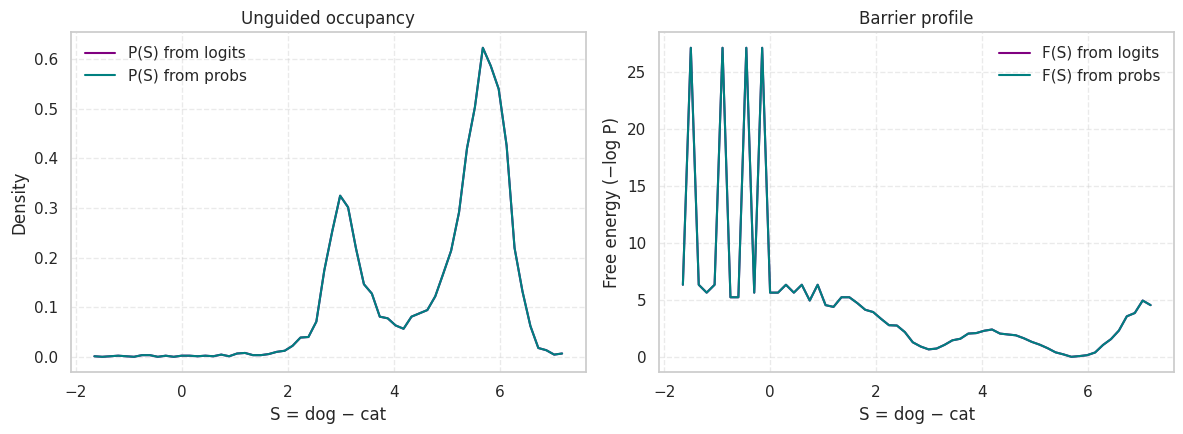

In [2]:
import os
import glob
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
if "apply_pub_style" in globals():
    apply_pub_style()

# --- CONFIGURATION ---
UNGUIDED_MANIFOLD_DIR = "/work/pcsl/Noam/sequential_diffusion/results/manifold_probe/ILSVRC2012_val_00000729/probe_noise_50"
MAX_MANIFOLD_TRAJS = 30
MAX_MANIFOLD_STEPS = None  # e.g., 200
BINS = 60

# Meta-class indices
DOG_INDICES = list(range(151, 269))
CAT_INDICES = list(range(281, 286))

OUTPUT_DIR = os.path.join(UNGUIDED_MANIFOLD_DIR, "plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- HELPERS ---

def maybe_export(path):
    if "export_to_notebook_dir" in globals():
        export_to_notebook_dir(path)
        return
    export_dir = os.path.join("notebooks", "_exports")
    os.makedirs(export_dir, exist_ok=True)
    try:
        import shutil
        shutil.copy(path, os.path.join(export_dir, os.path.basename(path)))
    except Exception:
        pass


def load_manifold_logits(base_dir, max_traj=None):
    files = sorted(glob.glob(os.path.join(base_dir, "traj_*", "manifold_logits.npz")))
    if not files:
        return None
    if max_traj is not None:
        files = files[:max_traj]
    logits_list = []
    for f in files:
        data = np.load(f)["logits"]  # [T, 1000]
        if MAX_MANIFOLD_STEPS is not None:
            data = data[:MAX_MANIFOLD_STEPS]
        logits_list.append(data)
    try:
        return np.stack(logits_list, axis=0)  # [N, T, 1000]
    except Exception:
        return None


def free_energy(values, bins=50):
    hist, edges = np.histogram(values, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    p = hist + 1e-12
    F = -np.log(p)
    F -= F.min()
    return centers, F, p

# --- LOAD ---
logits_stack = load_manifold_logits(UNGUIDED_MANIFOLD_DIR, MAX_MANIFOLD_TRAJS)
if logits_stack is None:
    print("No manifold logits found. Set UNGUIDED_MANIFOLD_DIR correctly.")
else:
    # logits_stack: [N, T, 1000]
    logits_t = th.tensor(logits_stack)  # float

    # S_logits = logsumexp(dog) - logsumexp(cat)
    cat_logits = th.logsumexp(logits_t[:, :, CAT_INDICES], dim=2)
    dog_logits = th.logsumexp(logits_t[:, :, DOG_INDICES], dim=2)
    S_logits = (dog_logits - cat_logits).flatten().numpy()

    # S_logprob = log prob mass(dog) - log prob mass(cat)
    logZ = th.logsumexp(logits_t, dim=2)
    logp_cat = cat_logits - logZ
    logp_dog = dog_logits - logZ
    S_logprob = (logp_dog - logp_cat).flatten().numpy()

    # Free energy curves
    x1, F1, p1 = free_energy(S_logits, bins=BINS)
    x2, F2, p2 = free_energy(S_logprob, bins=BINS)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

    ax1.plot(x1, p1, color="purple", label="P(S) from logits")
    ax1.plot(x2, p2, color="teal", label="P(S) from probs")
    ax1.set_xlabel("S = dog − cat")
    ax1.set_ylabel("Density")
    ax1.set_title("Unguided occupancy")
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.4)

    ax2.plot(x1, F1, color="purple", label="F(S) from logits")
    ax2.plot(x2, F2, color="teal", label="F(S) from probs")
    ax2.set_xlabel("S = dog − cat")
    ax2.set_ylabel("Free energy (−log P)")
    ax2.set_title("Barrier profile")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "unguided_barrier_profile.pdf")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"Saved: {out_path}")
    maybe_export(out_path)
    plt.show()
